# Классификация изображений с эмоциями людей

# <b>ВВЕДЕНИЕ</b>

Модели для данной работы были разработаны инструментами библиотек PyTorch, TensorFlow, Scikit-learn. После ряда экспериментов были отобраны по две модели на каждый фреймворк.

Используемый датасет собран нами вручную под конкретную задачу из имеющейся в нашем распоряжении базы данных изображений (около 140 тысяч изображений). Было отобрано 1380 изображений по пяти классам - anger, disgust, fear, joyfulness, neutral.

Конечный документ обучен с ипользованием GPU, предоставляемых платформой "Kaggle".

# <b>1. ПОДГОТОВИТЕЛЬНЫЙ ЭТАП</b>

Данную ячейку по очистке рабочей директории  запускать **ТОЛЬКО** в ноутбуках Kaggle перед началом обучения на GPU.

In [2]:
# # DO NOT RUN ON YOUR LOCAL MACHINE!!!

# import os
# dir_to_delete = '/kaggle/working/'
# with os.scandir(dir_to_delete) as entries:
#     for entry in entries:
#         file_to_delete = f"{dir_to_delete}{entry.name}"
#         if os.path.isfile(file_to_delete):
#             print(file_to_delete)
#             os.remove(file_to_delete)

# # Clear output folder
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# remove_folder_contents(folder_path)
# os.rmdir(folder_path)

In [3]:
# # активировать при обучении в Kaggle
!pip install gdown

# Установка и импорт необходимых библиотек

In [27]:
!pip install --pre torcheval-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.4 MB/s eta 0:00:00


In [28]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.4 MB/s eta 0:00:00


In [30]:
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00


In [1]:
import platform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torcheval.metrics.functional import multiclass_f1_score
from torch.utils.data import Dataset, DataLoader
# from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR
from torch.optim import lr_scheduler
import torch.backends.cudnn
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import tensorflow as tf

import sklearn
# from sklearn.model_selection import train_test_split

from tqdm import tqdm
import time
import wandb
import timm
import random
import copy
# import cv2
import datetime as dt

# import albumentations as A
# import albumentations.pytorch as AP
# from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, RandomCrop,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomScale, RandomGridShuffle,
    RandomContrast, RandomGamma, RandomBrightness, CenterCrop, VerticalFlip, ColorJitter,
    ChannelShuffle, InvertImg, RGBShift, ElasticTransform, Equalize, RandomResizedCrop, ChannelDropout
)

print('Python version:', platform.python_version())
print('pytorch version:', torch.__version__)
print('tensortlow version:', tf.__version__)
print('numpy version:', np.version.version)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)
print('matplotlib version:', matplotlib.__version__)
print('seaborn version:', sns.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.11.0
GPU Device Found.


# 1.1. Подготовка файлов для работы с локального диска

## Загрузка данных на локальный диск

In [4]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output=fname+'.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: /kaggle/working/emotions.zip
100%|██████████| 14.8M/14.8M [00:00<00:00, 86.9MB/s]


Распаковка в текущую директорию.

In [5]:
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Теперь загруженный архив можно удалить.

In [6]:
import os

os.remove(fname + '.zip')

Переименуем папку с изображениями в `emotions`. Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [7]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [8]:
zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [9]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

## Настройка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [10]:
from pathlib import Path

# Базовая директория
classes = sorted(os.listdir(base_dir))

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [11]:
# class_names = [x.lower() for x in classes]
class_names = sorted(['anger', 'disgust', 'fear', 'joyfulness', 'neutral'])

done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(sorted(class_names)):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = sorted(os.listdir(base_dir))

In [12]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

## Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [13]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [14]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] 5a971597aae6052a008b45a7.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] Universal_Expression_Disgust.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] gettyimages-520925691.webp: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [15]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


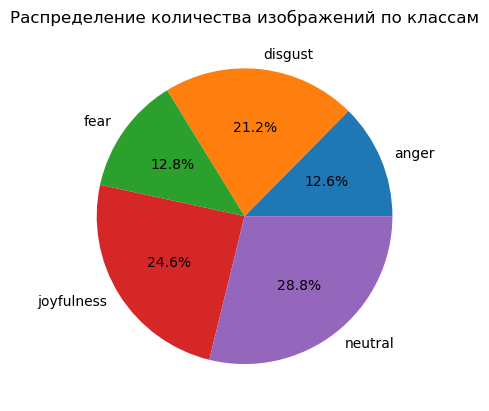

In [16]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать метрики, основанные на `precision` и `recall`, а также матрицу ошибок.

In [17]:
print(len(class_names))

5


Посмотрим на названия отдельных файлов.

In [18]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['77144.jpg', '96163.jpg', '82388.jpg']
disgust ['58139.jpg', '172104.jpg', '90895.jpg']
fear ['5970.jpg', '221981.jpg', '1891.jpg']
joyfulness ['4259.jpg', '1093.jpg', '1028.jpg']
neutral ['28111.jpg', '15494.jpg', '171255.jpg']


## Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

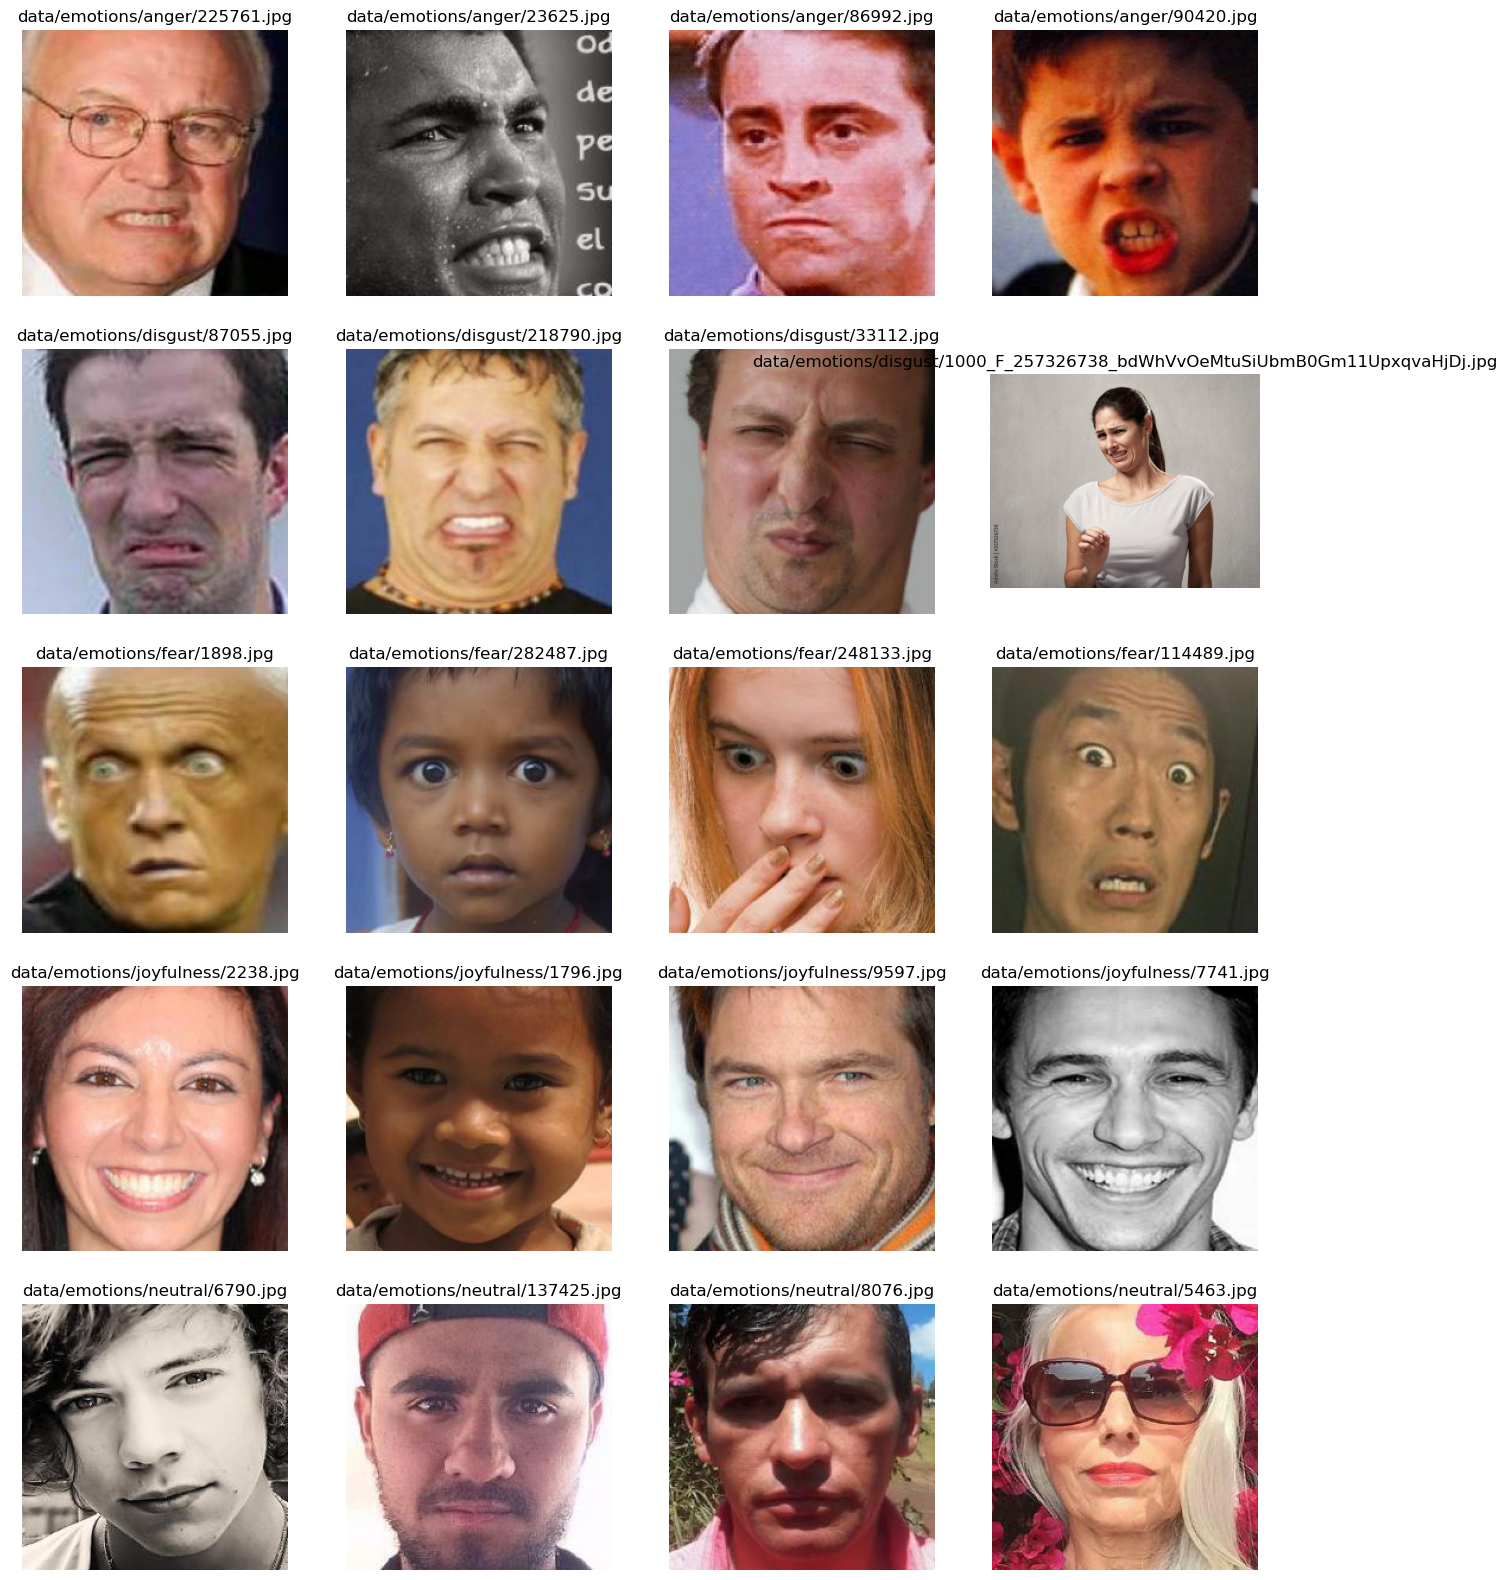

In [20]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для наших моделей. Этим мы сейчас и займемся.

## Создание DataFrame для "случайного леса"

Для "случайного леса" изображения необходимо перевести в векторы, объединить эти векторы в одну DataFrame, добавив последним столбцом номера классов (от 0 до 4, ординальная кодировка). Следующий код аккуратно проделает все операции, на выходе мы получаем желаемую DataFrame, после чего ее можно будет разделить средствами библиотеки sklearn на обучающую и валидационную части.

In [21]:
import pandas as pd
from PIL import Image

# создадим пустые списки для векторов по классам
anger_features = []
disgust_features = []
fear_features = []
joyfulness_features = []
neutral_features = []
features_lst= sorted([anger_features, disgust_features,
                      fear_features, joyfulness_features,
                      neutral_features])

# переведем изображения в вектора, добавим таргет
# и сохраним в списках
final_df = pd.DataFrame()  # пустой датафрейм
for name, lst in zip(class_names, features_lst):
    fpath = base_dir / name
    lst_idx = features_lst.index(lst)
    for img in os.listdir(fpath):

        img = Image.open(fpath/img)
        img = np.array(img)

        if img.shape == (224, 224, 3):

            a = np.reshape(img, (224*224*3))
            b = np.ones(1, dtype='uint8')*lst_idx
            c = np.append(a, b)
            lst.append(c)

    # добавим все данные в общую таблицу
    final_df = pd.concat([final_df, pd.DataFrame(lst)], axis=0)

final_df.index = range(final_df.shape[0])

In [22]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Columns: 150529 entries, 0 to 150528
dtypes: int8(150529)
memory usage: 197.0 MB


In [23]:
final_df.shape

(1372, 150529)

In [ ]:
final_df

0       1       2       3       4       5       6       7       8       \
0         30      30      30      25      25      25      19      19      19   
1         21      12       7      23      14       9      25      16      11   
2        107      87      60     106      86      59     107      86      59   
3         -1       0      -1      -1       0      -1      -1       0      -1   
4         33      14       0      35      16       2      38      20       6   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1367     -48     -35     -29     -55     -42     -36     -66     -55     -49   
1368     122    -120      83     114    -128      77      98     107      64   
1369      -5      -6      -8      -5      -6      -8      -5      -6      -8   
1370    -109    -123    -126     -95    -109    -112    -117     124     119   
1371      23      23      23      26      26      26      31      31      31   

      9       ...  150519  150520  150521  150522  150523  150524  150525  \
0         17  ...      48      48      48      45      45      45      40   
1         25  ...     -38       3      18     -40       4      18     -40   
2        111  ...     -60     -58     -43     -59     -57     -42     -58   
3         -1  ...      -1      -1       2      -1      -1       4      -1   
4         38  ...      90      54      30      84      48      24      78   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
1367     -73  ...     -44     -36     -23     -51     -43     -30     -53   
1368      80  ...      32      52      61      32      52      59      32   
1369      -5  ...      39      34      31      39      34      31      39   
1370     103  ...     -77    -114     123     -79    -116     124     -84   
1371      34  ...      87      87      87      70      70      70      72   

      150526  150527  150528  
0         40      40       0  
1          4      18       0  
2        -56     -41       0  
3         -1       4       0  
4         42      18       0  
...      ...     ...     ...  
1367     -45     -32       4  
1368      52      59       4  
1369      34      31       4  
1370    -124     122       4  
1371      72      72       4  

[1372 rows x 150529 columns]

## Split изображений для нейросетей

Так как для оценки работы нейросетей мы создаем отдельный датасет с тестовыми изображениями и в одном из используемых фреймворков (tensorflow) готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами. После этого создать датасеты для torch и tf будет несложно.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [24]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):

    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num

    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [25]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=sorted(classes)[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении примерно 8 : 1.2 : 0.8. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [26]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

train ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']
test ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']
validation ['neutral', 'disgust', 'anger', 'joyfulness', 'fear']


# 1.2. Подготовка функций, переменных и датасетов | <b>PyTorch</b>

## CFG класс

Подготовим CFG - класс с параметрами нашего эксперимента.

In [32]:
class CFG:

    num_workers=2
    model_name = 'ResNet emo'
    size=(224,224)
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42

    api = "c46873158d9b17d359eb43bbe31308d56f8ce3d4"  # вписать свой API Wandb  
    project = "ready_go"  # вписать название эксперимента, который предварительно надо создать в Wandb
    entity = "gret-ell"  # ввести свой логин
    wandb = False  # флаг использования Wandb

Переведем наш класс с параметрами в словарь.

In [33]:
def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [34]:
def seed_everything(seed):
    random.seed(CFG.seed)  # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(CFG.seed)  # фиксируем заполнения хешей. PYTHONHASHSEED переменная среды с фиксированным значением
    np.random.seed(CFG.seed)  # фиксируем генератор случайных чисел numpy
    torch.manual_seed(CFG.seed)  # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(CFG.seed)  # фиксируем генератор случайных чисел для GPU

## Данные для модели

In [35]:
# поканальные значения среднего и стандартного отклонения для ImageNet, на которых предобучены модели и которые используются в этой работе.
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

In [36]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Контроль изменения `learning_rate`

Определяем разные типы изменения скорости обучения.

In [ ]:
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

## Подготовка датасетов

In [37]:
dataset = torchvision.datasets.ImageFolder(base_dir)

In [38]:
dataset

Dataset ImageFolder
    Number of datapoints: 1380
    Root location: /content/data/emotions

In [39]:
# Data augmentation and normalization for training
# Только нормализация применима к validation
# ПРИМЕЧАНИЕ: использовать не более 2-х процессоров, иначе выходит предупреждение, что слишком высокое количество.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=CFG.batch_size,
                                             shuffle=True, num_workers=CFG.num_workers)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Функция для отрисовки изображений

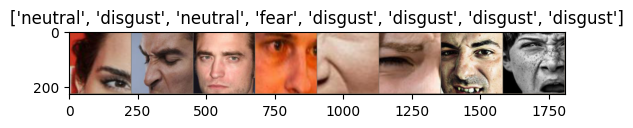

In [40]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.5)  # установим паузу, чтобы графики успевали обновлятся


# Берем батч из training data
inputs, classes = next(iter(dataloaders['train']))

# Вынимаем из батча изображение
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Функция для тренировки моделей. Общая

In [41]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=CFG.epochs):
    since = time.time()
    loss_hist = {'train':[], 'validation':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_f1 = 0.0

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # В каждой эпохе есть training и validation фаза
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Переводим модель в training mode
            else:
                model.eval()   # Переводим модель в evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Итерируемся.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                # forward
                # отслеживание истории только в train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize только если training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # подсчет статистики
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = multiclass_f1_score(outputs, labels, num_classes=len(class_names))

            print(f'{phase}   |   Loss: {epoch_loss:.4f}  |  Acc: {epoch_acc:.4f}   |   F1: {epoch_f1:.4f}')
            
            # Передача данных в сервис wandb
            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'validation':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc,
                   'test_F1': epoch_f1})
            # deep copy модели
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    

    # загрузка best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_hist

## Функция для визуализации результатов предсказания модели

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# 1.3. Подготовка функций, переменных и датасетов | <b>TensorFlow</b>

## Архитектура, компиляция, обучение модели

`DROPOUT_RATE` назначим небольшим, так как датасет у нас скромный по объему и, если мы будем исключать значительную часть датасета из обучения, модель просто не сможет обучаться.

Также назначим переменную базовый learning rate - `BASE_LR`, установим значение на 0.01. Мы будем использовать специальный инструмент `callbacks`, который при необходимости будет уменьшать данный параметр непосредственно в ходе обучения.

In [27]:
DROPOUT_RATE = 0.2
BASE_LR = 0.01
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)
EPOCHS=500  # см. callbacks

В качестве метрик будем использовать традиционную `accuracy` (в дань уважения традиции, для оценки работы классификатора на несбаланированных данных эта метрика не имеет большого смысла, так как она считает среднее по ошибкам, не учитывая крайности) и `PR-AUC` - площадь под графиком метрик precision и recall, которая позволяет учесть данные по редким классам и получить более объективную картину об эффективности обучения в нашем случае. Также можно было использовать метрику F1 Score, но готовый класс этой метрики на данный момент доступна только в "ночной" версии tf, а прописывать свой собственный класс мы не стали в связи с наличием готового инструмента PR-AUC, вполне удовлетворяющего нашим задачам.

In [28]:
curve = 'PR'
name = curve+'_AUC'
AUC = tf.keras.metrics.AUC(curve=curve, multi_label=False, name=name)

# список с метриками
metrics = ['accuracy', AUC]

## Callbacks - контроль `learning_rate` и остановки обучения

Так как обучение моделей по компьютерному зрению очень затратно по ресурсам, а мы проводили целый ряд различных экспериментов, для снижения нагрузки на систему мы использовали так называемые `callbacks` - специальные модули `keras`, которые позволяют в автомтическом режиме контролировать, когда следует вносить те или иные изменения в обучение и даже останавливать его. Мы будем использовать два вида `callbacks`:

- `EarlyStopping` для ранней остановки обучения при прекращении уменьшения `val_loss` (для нашего несбалансированного датасета этот показатель важнее, чем непоказательный для несбалансированных классов `val_accuracy`),

- `ReduceLROnPlateau` для уменьшения `learning rate` при ухудшении показателей `val_loss` (постепенное снижение `learning rate` в процессе обучения положительно сказывается на качестве обучения, что мы увидели на наших экспериментах).

In [29]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,  # минимальное значение для зачета улучшения
    patience=12,  # количество эпох с плохим результатом перед остановкой
    restore_best_weights=True,  # восстановить лучшие показатели модели
)

# early_stopping = callbacks.EarlyStopping(
#     monitor='val_PR_AUC',
#     min_delta=1e-4,  # минимальное значение для зачета улучшения
#     patience=12,  # количество эпох с плохим результатом перед остановкой
#     restore_best_weights=True,  # восстановить лучшие показатели модели
#     mode="max"
# )

lr_schedule = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=1,
    factor=0.85,  # на какое значение будет умножаться текущий lr
    min_lr=1e-8  # минимальное значение lr
)

Таким образом, наши callbacks создают следующий алгоритм: 
- при ухудшении `val_loss` на данной эпохе следующая эпоха будет прходить с `learning rate` на 15% ниже,
- если `val_loss` не улучшается 12 раз кряду, обучение прекращается.

Все эти параметры можно регулировать и подбирать, для наших задач мы остановимся на этих гиперпараметрах, так как в ходе экспериментов они показали себя достаточно эффективными.

## Визуализация итогов обучения

Также пропишем функции для отрисовки результатов обучения - графики функции потерь и метрик (обучающая и валидационная выборка), а также матрицу ошибок (тестовая выборка).

### Функция потерь и метрики

In [30]:
def val_acc_viz(history, epochs, loss_from=1):
    '''
    Функция отрисовывает историю функции потерь и
    используемых метрик. Аргументы:
    - history - данные истории обучения,
    - epochs - количество эпох для отображения,
    - loss_from - с какой эпохи отображать loss.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    auc = history.history[name]
    val_auc = history.history['val_' + name]

    loss = history.history['loss'][loss_from-1:]
    val_loss = history.history['val_loss'][loss_from-1:]

    epochs_range = range(1, len(acc)+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(loss_from, len(acc)+1), loss, label='Training Loss')
    plt.plot(range(loss_from, len(acc)+1), val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    # plt.show()

    # plt.figure(figsize=(8, 5))
    # ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 3, 2)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    # plt.subplot(1, 2, 2, sharey=ax1)
    plt.subplot(1, 3, 3, sharey=ax2)
    plt.plot(epochs_range, auc, label='Training ' + name)
    plt.plot(epochs_range, val_auc, label='Validation ' + name)
    plt.legend(loc='best')
    plt.title(name)
    plt.xlabel('epochs')
    plt.show()

### Функция матрицы ошибок

В функции матрицы ошибок использованы инструменты библиотеки scikit-learn, что особенно удобно для отрисовки матрицы, хотя при желании можно прописать функцию отрисовки матрицы вручную.

In [31]:
def confusion_matrix(model, dataset, images_number=None, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - dataset - tf.dataset с тестовыми изображениями.
    - images_number - int: количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке (по
            условию).
    - class_names - list: названия классов.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    
    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)

    y_test = list()
    y_pred = list()
    for x, y in test_batches:
        y_test.append(np.argmax(y))
        y_pred.append(np.argmax(model.predict(x, verbose=0)))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='GnBu')
    # disp.plot(cmap='afmhot')

    plt.show()

## Предсказания на изображениях из тестовой выборки

Следующая функция покажет предсказания по заданному числу изображений из тестовой выборки (по условию 10), реальное и предсказанное значение класса, изображение при активации `visualization`), а также "уверенность" модели в своем предсказании. 

In [32]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, dataset,
                     images_number=10, visualization=False):

    '''
    Функция предсказания по заданному числу изображений из тестовой
    выборки (по условию 10), реальное и предсказанное значение класса,
    изображение при активации `visualization`), а также
    "уверенность" модели в своем предсказании.
    
    Аргументы:
    -  model - обученная модель.
    - images_number - int: количество изображений, предсказания по которым
      мы хотим получить (по условию 10).
    - visualization - bool: отрисовка изображений (по условию False).
    
    '''
    
    images = dataset.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img, verbose=0)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

## Подготовка датасетов

Подготовим все необходимые переменные для создания датасетов под данные модели. На данном этапе пропишем переменные для первой модели с использованием InceptionV3, чтобы проверить корректность работы всех инструментов. Для второй модели мы внесем изменения в свое время.

### Гиперпараметры для модели с переносом обучения

Пропишем гиперпараметры для модели, которые обеспечат нам правильную работу алгоритма.

In [33]:
MODULE_HANDLE = 'tf.keras.applications.InceptionV3'

pixels = 299  # разрешение изображений, используемое в InceptionV3

IMAGE_SIZE = (pixels, pixels)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 32

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.InceptionV3, входное разрешение: (299, 299), размер батча: 32.


### Создание датасетов | `image_dataset_from_directory`

Для обучения модели предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`. В качестве `label_mode` установим `categorical` для перевода лейблов в вид `one_hot_encoding`.

Весь необходимый код оформим в функцию, которая в одну строчку создаст три датасета под любую предобученную модель.

In [34]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical',
                  seed=123):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [35]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [36]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(32, 299, 299, 3)
(32, 299, 299, 3)
(1, 299, 299, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [37]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)

class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


### Визуализация изображений из `train_batches`

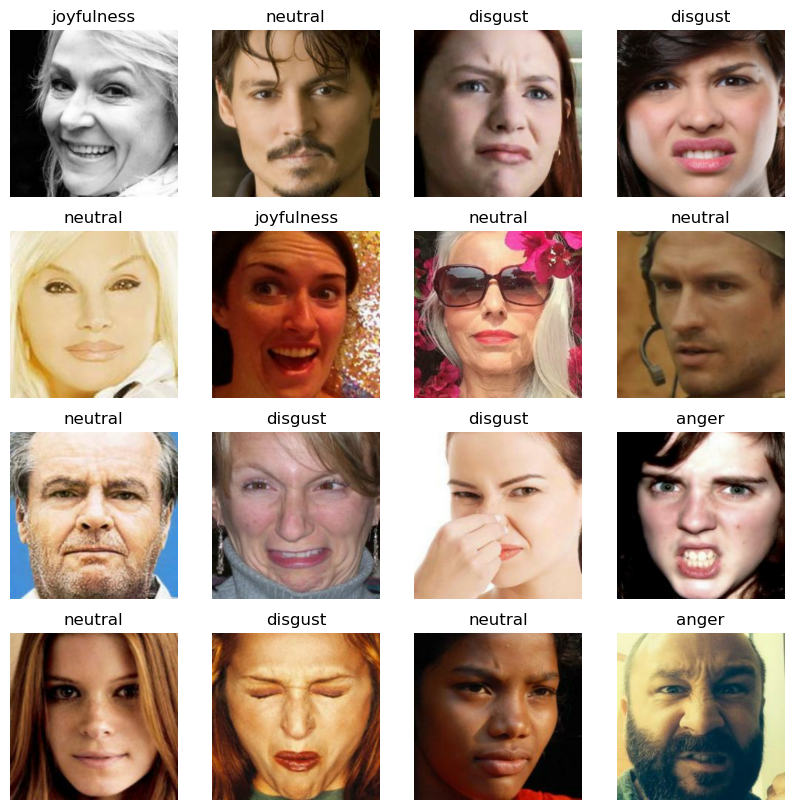

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

In [39]:
# одно случайное изображение
for images, labels in train_batches.take(30):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

(299, 299, 3)


Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

### Слои для препроцессинга изображений

#### Rescale

Стандартизация значений матриц изображений - обязательная операция, если мы хотим получить хорошие результаты по работе нашей сети. Для использования данной предобученной модели значения матриц изображений необходимо отшкалировать по стандарту от -1 до 1 (именно такой стандарт использовался для обучения этой сети). Есть два способа создания соответствующего слоя:

```python
# для модели InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

или

# для любой модели
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
```

In [40]:
rescale = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./127.5, offset=-1,
                                  input_shape=IMAGE_SIZE + (3,),
                                  name='Rescaling')
])

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Минимальное и максимальное значение пикселей: -0.9764706 1.0


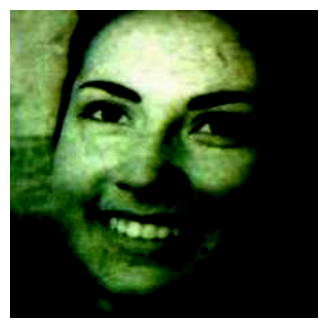

In [41]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(one_pic, axis=0))
# print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
# print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения. Это нормально, так как значения матрицы изображений были растянуты по обе стороны от 0. В любом случае, алгоритм обнаруживает зависимости не по внешнему виду картинок, как человеческий глаз, а исходя из числовых значений тензоров изображений.

#### Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast` (отключен). 

In [42]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.3), name='RandomZoom'),
    # tf.keras.layers.RandomContrast(factor=(0.1, 0.1), name='RandomContrast')
])

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

Минимальное и максимальное значение пикселей: -0.93750995 1.0


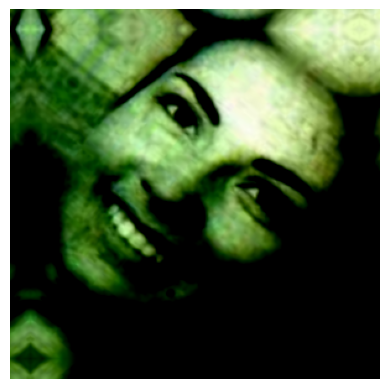

In [43]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(result, axis=0)
augmented = data_aug(result_for_aug).numpy()
# print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented));

print("Минимальное и максимальное значение пикселей:", augmented.min(), augmented.max())

Итак, обе последовательности успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

## Оптимизация работы кэша

In [44]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>2. МОДЕЛИ</b>

# <b>2.1. PyTorch</b>

## <b>Модель 2.1.1 | Resnet18</b>

### Замороженные слои

In [60]:
model_conv = torchvision.models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_conv.parameters():
    param.requires_grad = False  # Заморозим слои и проверим качество предсказаний

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

scheduler = get_scheduler(optimizer_conv)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [61]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_conv, 
        input_size=(8, 3, 224, 224), # входной батч
        col_names=["input_size", "output_size", "num_params"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNet                                   [8, 3, 224, 224]     [8, 5]               --
├─Conv2d: 1-1                            [8, 3, 224, 224]     [8, 64, 112, 112]    (9,408)
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]    [8, 64, 112, 112]    (128)
├─ReLU: 1-3                              [8, 64, 112, 112]    [8, 64, 112, 112]    --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]    [8, 64, 56, 56]      --
├─Sequential: 1-5                        [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]      [8, 64, 56, 56]      (36,864)
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]      [8, 64, 56, 56]      (128)
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-4         

In [62]:
model_conv, loss_hist = train_model(model_conv, criterion, optimizer_conv,
                         scheduler, num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:04<00:00, 31.76it/s]


train   |   Loss: 1.5763  |  Acc: 0.3389   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 27.18it/s]


validation   |   Loss: 1.3274  |  Acc: 0.4403   |   F1: 0.4286

Epoch 1/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.52it/s]


train   |   Loss: 1.3640  |  Acc: 0.4694   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 24.78it/s]


validation   |   Loss: 1.3029  |  Acc: 0.4717   |   F1: 0.4286

Epoch 2/29
----------


100%|██████████| 135/135 [00:04<00:00, 31.56it/s]


train   |   Loss: 1.3331  |  Acc: 0.4667   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.49it/s]


validation   |   Loss: 1.2958  |  Acc: 0.4465   |   F1: 0.7143

Epoch 3/29
----------


100%|██████████| 135/135 [00:03<00:00, 34.45it/s]


train   |   Loss: 1.2691  |  Acc: 0.4870   |   F1: 0.3750


100%|██████████| 20/20 [00:00<00:00, 25.13it/s]


validation   |   Loss: 1.1855  |  Acc: 0.5409   |   F1: 0.5714

Epoch 4/29
----------


100%|██████████| 135/135 [00:04<00:00, 31.25it/s]


train   |   Loss: 1.2616  |  Acc: 0.5046   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 23.61it/s]


validation   |   Loss: 1.2738  |  Acc: 0.4969   |   F1: 0.2857

Epoch 5/29
----------


100%|██████████| 135/135 [00:05<00:00, 26.14it/s]


train   |   Loss: 1.2480  |  Acc: 0.5111   |   F1: 0.3750


100%|██████████| 20/20 [00:00<00:00, 28.11it/s]


validation   |   Loss: 1.2489  |  Acc: 0.5220   |   F1: 0.4286

Epoch 6/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.85it/s]


train   |   Loss: 1.2029  |  Acc: 0.5185   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 27.75it/s]


validation   |   Loss: 1.1491  |  Acc: 0.5031   |   F1: 0.4286

Epoch 7/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.87it/s]


train   |   Loss: 1.1705  |  Acc: 0.5444   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.46it/s]


validation   |   Loss: 1.0971  |  Acc: 0.5849   |   F1: 0.4286

Epoch 8/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.92it/s]


train   |   Loss: 1.1748  |  Acc: 0.5417   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 27.55it/s]


validation   |   Loss: 1.1293  |  Acc: 0.5597   |   F1: 0.2857

Epoch 9/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.97it/s]


train   |   Loss: 1.1230  |  Acc: 0.5509   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.92it/s]


validation   |   Loss: 1.1718  |  Acc: 0.5660   |   F1: 0.8571

Epoch 10/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.24it/s]


train   |   Loss: 1.1699  |  Acc: 0.5324   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 23.25it/s]


validation   |   Loss: 1.2976  |  Acc: 0.5031   |   F1: 0.5714

Epoch 11/29
----------


100%|██████████| 135/135 [00:04<00:00, 27.06it/s]


train   |   Loss: 1.1597  |  Acc: 0.5426   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.08it/s]


validation   |   Loss: 1.0945  |  Acc: 0.5660   |   F1: 0.7143

Epoch 12/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.14it/s]


train   |   Loss: 1.1928  |  Acc: 0.5306   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 22.01it/s]


validation   |   Loss: 1.2497  |  Acc: 0.5346   |   F1: 0.5714

Epoch 13/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.32it/s]


train   |   Loss: 1.1830  |  Acc: 0.5343   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 28.64it/s]


validation   |   Loss: 1.1772  |  Acc: 0.5660   |   F1: 1.0000

Epoch 14/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.70it/s]


train   |   Loss: 1.1332  |  Acc: 0.5593   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.91it/s]


validation   |   Loss: 1.0611  |  Acc: 0.5975   |   F1: 0.4286

Epoch 15/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.14it/s]


train   |   Loss: 1.1550  |  Acc: 0.5602   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 28.09it/s]


validation   |   Loss: 1.1575  |  Acc: 0.5220   |   F1: 0.5714

Epoch 16/29
----------


100%|██████████| 135/135 [00:03<00:00, 33.76it/s]


train   |   Loss: 1.0950  |  Acc: 0.5685   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.55it/s]


validation   |   Loss: 1.0957  |  Acc: 0.5660   |   F1: 0.4286

Epoch 17/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.97it/s]


train   |   Loss: 1.1365  |  Acc: 0.5537   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.92it/s]


validation   |   Loss: 1.1800  |  Acc: 0.5220   |   F1: 0.5714

Epoch 18/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.63it/s]


train   |   Loss: 1.1134  |  Acc: 0.5694   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.84it/s]


validation   |   Loss: 1.1679  |  Acc: 0.5409   |   F1: 0.4286

Epoch 19/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.35it/s]


train   |   Loss: 1.1525  |  Acc: 0.5528   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.92it/s]


validation   |   Loss: 1.1647  |  Acc: 0.5723   |   F1: 0.5714

Epoch 20/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.36it/s]


train   |   Loss: 1.0451  |  Acc: 0.6056   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.57it/s]


validation   |   Loss: 1.0750  |  Acc: 0.5786   |   F1: 0.4286

Epoch 21/29
----------


100%|██████████| 135/135 [00:04<00:00, 30.41it/s]


train   |   Loss: 1.0224  |  Acc: 0.5972   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 28.26it/s]


validation   |   Loss: 1.0633  |  Acc: 0.5786   |   F1: 0.8571

Epoch 22/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.56it/s]


train   |   Loss: 1.0317  |  Acc: 0.5944   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.14it/s]


validation   |   Loss: 1.0758  |  Acc: 0.5975   |   F1: 0.5714

Epoch 23/29
----------


100%|██████████| 135/135 [00:04<00:00, 29.84it/s]


train   |   Loss: 1.0453  |  Acc: 0.5824   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 14.02it/s]


validation   |   Loss: 1.0760  |  Acc: 0.5723   |   F1: 0.5714

Epoch 24/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.71it/s]


train   |   Loss: 1.0324  |  Acc: 0.5954   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.22it/s]


validation   |   Loss: 1.0788  |  Acc: 0.5849   |   F1: 0.5714

Epoch 25/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.32it/s]


train   |   Loss: 1.0303  |  Acc: 0.5954   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 21.31it/s]


validation   |   Loss: 1.0496  |  Acc: 0.5849   |   F1: 0.2857

Epoch 26/29
----------


100%|██████████| 135/135 [00:04<00:00, 33.37it/s]


train   |   Loss: 1.0329  |  Acc: 0.5889   |   F1: 0.5000


100%|██████████| 20/20 [00:00<00:00, 28.01it/s]


validation   |   Loss: 1.0792  |  Acc: 0.6164   |   F1: 0.7143

Epoch 27/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.77it/s]


train   |   Loss: 1.0322  |  Acc: 0.6148   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 28.02it/s]


validation   |   Loss: 1.0737  |  Acc: 0.5723   |   F1: 0.7143

Epoch 28/29
----------


100%|██████████| 135/135 [00:04<00:00, 29.13it/s]


train   |   Loss: 1.0473  |  Acc: 0.5981   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 27.51it/s]


validation   |   Loss: 1.0760  |  Acc: 0.5597   |   F1: 0.5714

Epoch 29/29
----------


100%|██████████| 135/135 [00:04<00:00, 32.95it/s]


train   |   Loss: 1.0868  |  Acc: 0.5870   |   F1: 0.2500


100%|██████████| 20/20 [00:00<00:00, 28.54it/s]

validation   |   Loss: 1.0714  |  Acc: 0.5660   |   F1: 0.7143

Training complete in 2m 32s
Best val Acc: 0.616352


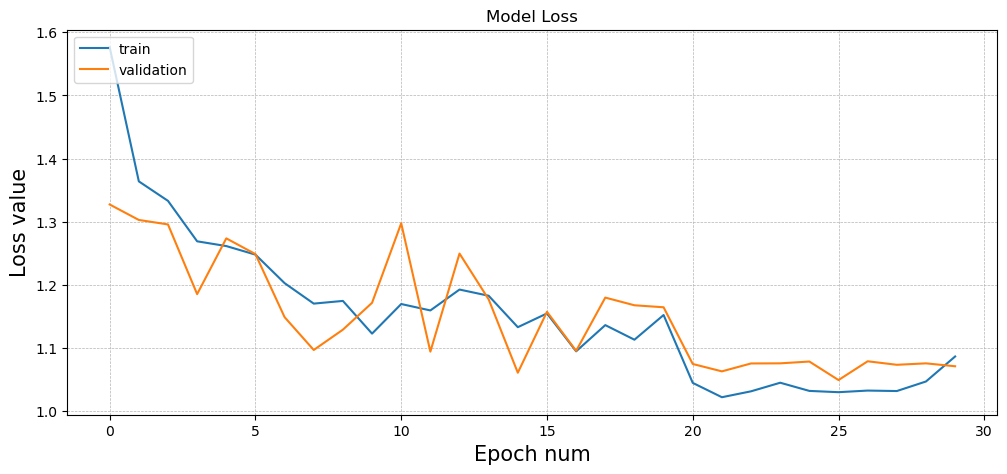

In [63]:
plt.rcParams['figure.figsize'] = (12, 5)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

#### Предсказание модели

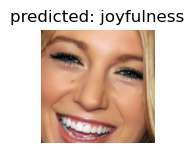

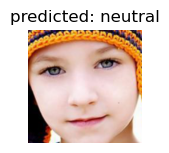

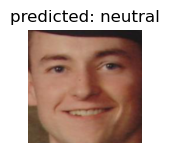

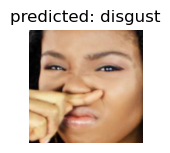

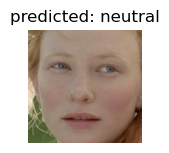

In [64]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#### Оценка работы модели

F1-Score macro:  0.5803123789722578
F1-Score micro:  0.6163522012578616
F1-Score weighted:  0.6071061368669043
[25.         67.64705882 60.         69.23076923 67.39130435]


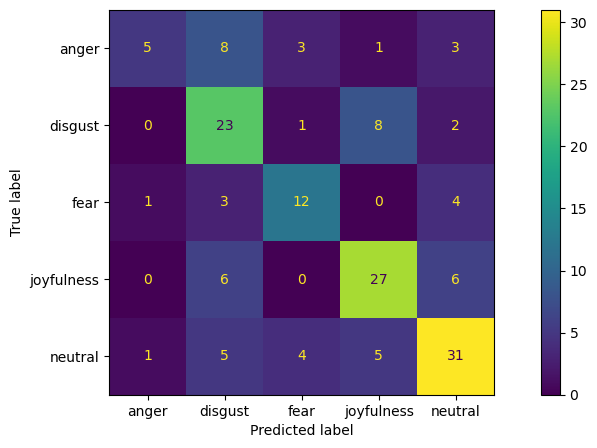

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_conv(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
#print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
print('========================================================')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

### Разморозка слоев

Первая модель. Предобученная модель Resnet18. По рекомендациям разработчика, теперь надо указывать не pretrained=True, а предобученные веса модели.

In [87]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True. Рекомендации разработчика использовать веса, вместо pretrained=True

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

scheduler = get_scheduler(optimizer_ft)

# Уменьшим LR на  0.1 каждые 7 эпох
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [88]:
# Вывод информации о модели с помощью torchinfo
summary(model=model_ft, 
        input_size=(8, 3, 224, 224), # входной батч
        col_names=["input_size", "output_size", "num_params"], # что хотим посмотреть
        col_width=20
)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
ResNet                                   [8, 3, 224, 224]     [8, 5]               --
├─Conv2d: 1-1                            [8, 3, 224, 224]     [8, 64, 112, 112]    9,408
├─BatchNorm2d: 1-2                       [8, 64, 112, 112]    [8, 64, 112, 112]    128
├─ReLU: 1-3                              [8, 64, 112, 112]    [8, 64, 112, 112]    --
├─MaxPool2d: 1-4                         [8, 64, 112, 112]    [8, 64, 56, 56]      --
├─Sequential: 1-5                        [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    └─BasicBlock: 2-1                   [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-1                  [8, 64, 56, 56]      [8, 64, 56, 56]      36,864
│    │    └─BatchNorm2d: 3-2             [8, 64, 56, 56]      [8, 64, 56, 56]      128
│    │    └─ReLU: 3-3                    [8, 64, 56, 56]      [8, 64, 56, 56]      --
│    │    └─Conv2d: 3-4                 

In [89]:
model_ft, loss_hist = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.82it/s]


train   |   Loss: 1.4161  |  Acc: 0.4046   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.07it/s]


validation   |   Loss: 0.8916  |  Acc: 0.6792   |   F1: 0.8571

Epoch 1/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.29it/s]


train   |   Loss: 1.0817  |  Acc: 0.5824   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 18.79it/s]


validation   |   Loss: 0.7519  |  Acc: 0.7170   |   F1: 0.5714

Epoch 2/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.82it/s]


train   |   Loss: 1.0416  |  Acc: 0.5981   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 29.01it/s]


validation   |   Loss: 0.7098  |  Acc: 0.7547   |   F1: 0.8571

Epoch 3/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.06it/s]


train   |   Loss: 0.8569  |  Acc: 0.6796   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 18.38it/s]


validation   |   Loss: 0.6218  |  Acc: 0.7673   |   F1: 0.8571

Epoch 4/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.03it/s]


train   |   Loss: 0.7688  |  Acc: 0.7037   |   F1: 0.6250


100%|██████████| 20/20 [00:00<00:00, 28.44it/s]


validation   |   Loss: 0.7600  |  Acc: 0.7358   |   F1: 0.7143

Epoch 5/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.66it/s]


train   |   Loss: 0.7790  |  Acc: 0.7028   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 16.73it/s]


validation   |   Loss: 0.6754  |  Acc: 0.7610   |   F1: 0.4286

Epoch 6/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.56it/s]


train   |   Loss: 0.6830  |  Acc: 0.7398   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 28.83it/s]


validation   |   Loss: 0.6274  |  Acc: 0.7987   |   F1: 0.8571

Epoch 7/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.23it/s]


train   |   Loss: 0.6671  |  Acc: 0.7694   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 17.43it/s]


validation   |   Loss: 0.5361  |  Acc: 0.8302   |   F1: 0.7143

Epoch 8/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.49it/s]


train   |   Loss: 0.5561  |  Acc: 0.7824   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.40it/s]


validation   |   Loss: 0.6589  |  Acc: 0.8176   |   F1: 1.0000

Epoch 9/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.20it/s]


train   |   Loss: 0.5565  |  Acc: 0.7963   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.16it/s]


validation   |   Loss: 0.6558  |  Acc: 0.8365   |   F1: 0.7143

Epoch 10/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.98it/s]


train   |   Loss: 0.5690  |  Acc: 0.7917   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 28.67it/s]


validation   |   Loss: 0.5880  |  Acc: 0.8491   |   F1: 0.5714

Epoch 11/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.11it/s]


train   |   Loss: 0.5327  |  Acc: 0.8000   |   F1: 0.7500


100%|██████████| 20/20 [00:02<00:00,  8.84it/s]


validation   |   Loss: 0.5925  |  Acc: 0.8239   |   F1: 0.7143

Epoch 12/29
----------


100%|██████████| 135/135 [00:08<00:00, 16.54it/s]


train   |   Loss: 0.5637  |  Acc: 0.8046   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 28.41it/s]


validation   |   Loss: 0.5572  |  Acc: 0.8365   |   F1: 0.8571

Epoch 13/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.86it/s]


train   |   Loss: 0.5325  |  Acc: 0.8111   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 17.70it/s]


validation   |   Loss: 0.7430  |  Acc: 0.7673   |   F1: 0.8571

Epoch 14/29
----------


100%|██████████| 135/135 [00:05<00:00, 22.89it/s]


train   |   Loss: 0.4841  |  Acc: 0.8269   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.88it/s]


validation   |   Loss: 0.5607  |  Acc: 0.8239   |   F1: 1.0000

Epoch 15/29
----------


100%|██████████| 135/135 [00:05<00:00, 23.90it/s]


train   |   Loss: 0.4451  |  Acc: 0.8352   |   F1: 0.6250


100%|██████████| 20/20 [00:01<00:00, 16.93it/s]


validation   |   Loss: 0.6356  |  Acc: 0.7987   |   F1: 1.0000

Epoch 16/29
----------


100%|██████████| 135/135 [00:06<00:00, 22.16it/s]


train   |   Loss: 0.4708  |  Acc: 0.8176   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 28.75it/s]


validation   |   Loss: 0.5243  |  Acc: 0.8365   |   F1: 0.8571

Epoch 17/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.37it/s]


train   |   Loss: 0.4160  |  Acc: 0.8509   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


validation   |   Loss: 0.9044  |  Acc: 0.7610   |   F1: 0.5714

Epoch 18/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.88it/s]


train   |   Loss: 0.4661  |  Acc: 0.8176   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 27.61it/s]


validation   |   Loss: 0.6471  |  Acc: 0.8176   |   F1: 0.8571

Epoch 19/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.65it/s]


train   |   Loss: 0.4698  |  Acc: 0.8194   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 17.28it/s]


validation   |   Loss: 0.5902  |  Acc: 0.8239   |   F1: 1.0000

Epoch 20/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.71it/s]


train   |   Loss: 0.3632  |  Acc: 0.8556   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 26.69it/s]


validation   |   Loss: 0.5102  |  Acc: 0.8742   |   F1: 0.7143

Epoch 21/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.05it/s]


train   |   Loss: 0.2986  |  Acc: 0.8991   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 18.70it/s]


validation   |   Loss: 0.4923  |  Acc: 0.8553   |   F1: 0.8571

Epoch 22/29
----------


100%|██████████| 135/135 [00:06<00:00, 21.11it/s]


train   |   Loss: 0.3366  |  Acc: 0.8769   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


validation   |   Loss: 0.5207  |  Acc: 0.8491   |   F1: 0.8571

Epoch 23/29
----------


100%|██████████| 135/135 [00:05<00:00, 24.99it/s]


train   |   Loss: 0.3202  |  Acc: 0.8880   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


validation   |   Loss: 0.4998  |  Acc: 0.8616   |   F1: 0.7143

Epoch 24/29
----------


100%|██████████| 135/135 [00:06<00:00, 20.72it/s]


train   |   Loss: 0.3139  |  Acc: 0.8824   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.77it/s]


validation   |   Loss: 0.4917  |  Acc: 0.8553   |   F1: 0.8571

Epoch 25/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.07it/s]


train   |   Loss: 0.3045  |  Acc: 0.8972   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.15it/s]


validation   |   Loss: 0.4831  |  Acc: 0.8553   |   F1: 0.8571

Epoch 26/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.80it/s]


train   |   Loss: 0.3217  |  Acc: 0.8935   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 27.77it/s]


validation   |   Loss: 0.4800  |  Acc: 0.8491   |   F1: 1.0000

Epoch 27/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.00it/s]


train   |   Loss: 0.2882  |  Acc: 0.8963   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 28.65it/s]


validation   |   Loss: 0.5099  |  Acc: 0.8553   |   F1: 1.0000

Epoch 28/29
----------


100%|██████████| 135/135 [00:06<00:00, 19.82it/s]


train   |   Loss: 0.3094  |  Acc: 0.8861   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.69it/s]


validation   |   Loss: 0.4915  |  Acc: 0.8365   |   F1: 0.4286

Epoch 29/29
----------


100%|██████████| 135/135 [00:05<00:00, 25.01it/s]


train   |   Loss: 0.2929  |  Acc: 0.8954   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 27.72it/s]

validation   |   Loss: 0.5125  |  Acc: 0.8616   |   F1: 0.7143

Training complete in 3m 26s
Best val Acc: 0.874214


#### Предсказание модели

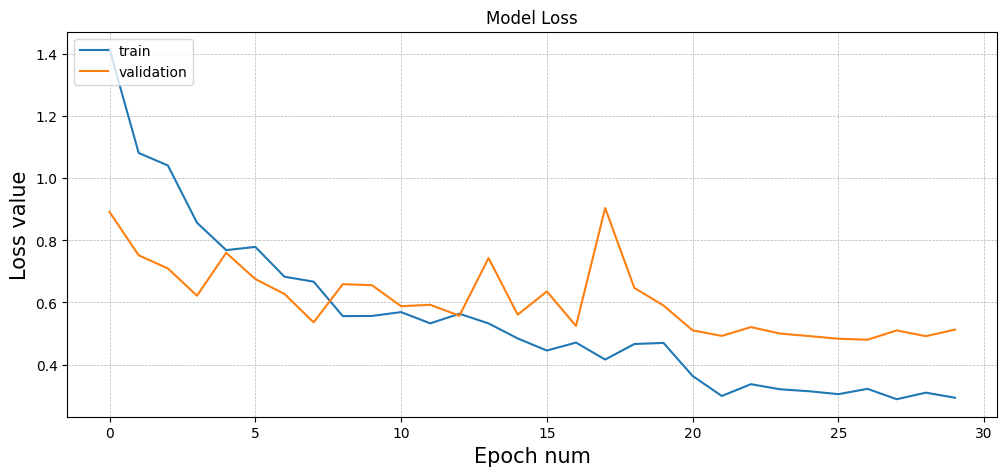

In [90]:
plt.rcParams['figure.figsize'] = (12, 5)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

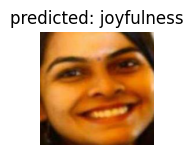

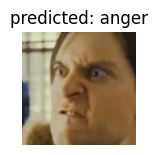

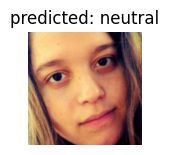

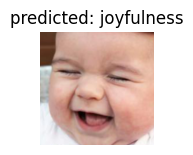

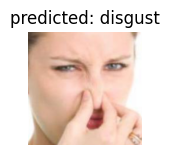

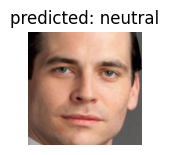

In [91]:
visualize_model(model_ft)

#### Оценка работы модели

F1-Score macro:  0.8499912322228879
F1-Score micro:  0.8742138364779874
F1-Score weighted:  0.8728784202427462
[70.         85.29411765 75.         94.87179487 95.65217391]


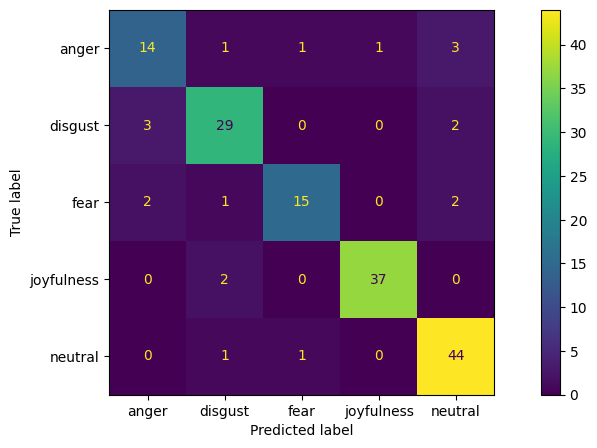

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

## <b>Модель 2.1.2 | EfficientNet_b0</b>

Приведенный ниже график, взятый из [статьи](https://learnopencv.com/efficientnet-theory-code/), показывает кривую производительности семейства EfficientNet.


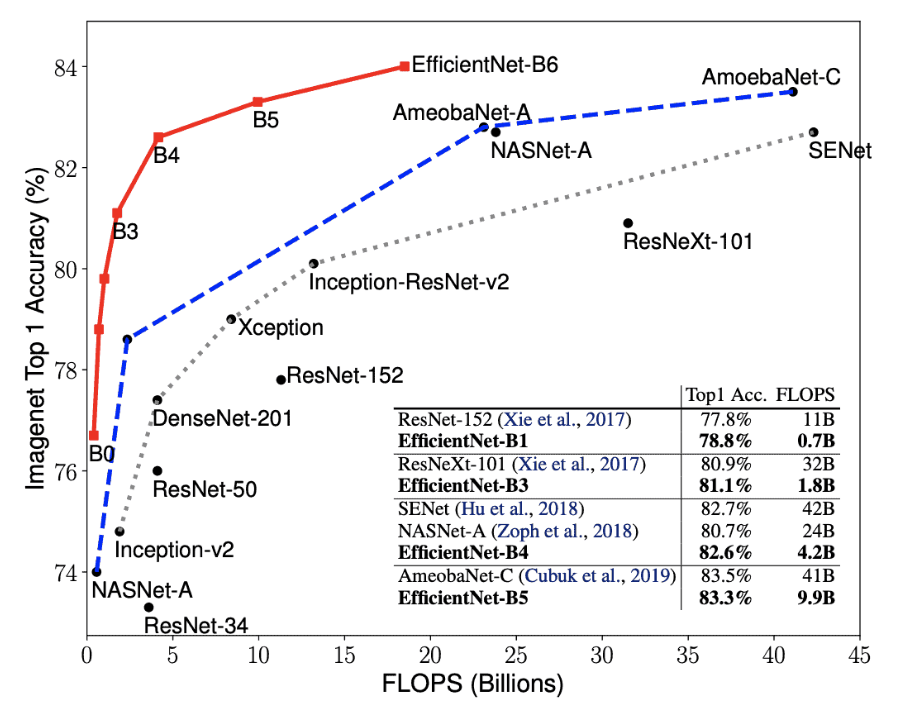

Производительность EfficientNet по сравнению с другими архитектурами CNN. 
Это показывает, что при тех же сбоях точность EfficientNet выше, чем у любой существующей архитектуры. Итак, если вы планируете использовать Inception-v2, вам следует рассмотреть возможность использования EfficientNet-B1 вместо этого. Аналогичным образом, рекомендуется рассмотреть EfficientNet-B2, если вы планируете использовать ResNet-50.

В большинстве реальных приложений люди начинают с предварительно обученной модели и настраивают ее для своего конкретного применения.

Только потому, что EfficientNet превосходит другие сети, означает ли это, что он будет превосходить другие сети в других задачах?

Хорошей новостью является то, что авторы провели эти эксперименты и показали, что при использовании магистрали EfficientNet мы также получаем лучшую производительность в других задачах компьютерного зрения.


Проход обучения предобученной модели без заморозки слоев EfficientNet B0 из библиотеки Timm

In [93]:
# Посмортим какие имеются претренированные модели
timm.list_models(pretrained=True)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

### Замороженные слои

In [94]:
efficientnet = timm.create_model('efficientnet_b0', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [95]:
class My_Net_efficientnet_b0(torch.nn.Module):
    def __init__(self, model_name, pretrained=True, effnet=False, value=False):  
        super().__init__()
        self.model = efficientnet

        # Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
        for param in self.model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
           #param.requires_grad = True  Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать            
           #fc_inputs = self.model.classifier.in_features # Добавляем полносвязанную классифицирующую голову
           self.model.classifier = nn.Sequential(
           nn.Linear(1280, 256),
           nn.ReLU(),
           nn.Linear(256, num_classes))


    def forward(self, x):
        x = self.model(x)
        return x

In [96]:
# Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этой модели на датасете ImageNet
model_efficientnet_b0 = My_Net_efficientnet_b0(model_name = 'efficientnet_b0', pretrained=True)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_efficientnet_b0 = model_efficientnet_b0.to(device)
 
# Определяем Loss функцию
# В данном случае - это кросс-энтропия
criterion = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска AdamW
optimizer = torch.optim.AdamW(model_efficientnet_b0.parameters(), lr=CFG.lr) 

scheduler = get_scheduler(optimizer)

In [97]:
print(model_efficientnet_b0)

My_Net_efficientnet_b0(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

In [98]:
summary(model=model_efficientnet_b0, 
        input_size=(8, 3, 256, 256), # входной батч
        col_names=["input_size", "output_size", "num_params"],
        col_width=20
)

Layer (type:depth-idx)                             Input Shape          Output Shape         Param #
My_Net_efficientnet_b0                             [8, 3, 256, 256]     [8, 5]               --
├─EfficientNet: 1-1                                [8, 3, 256, 256]     [8, 5]               --
│    └─Conv2d: 2-1                                 [8, 3, 256, 256]     [8, 32, 128, 128]    864
│    └─BatchNormAct2d: 2-2                         [8, 32, 128, 128]    [8, 32, 128, 128]    64
│    │    └─Identity: 3-1                          [8, 32, 128, 128]    [8, 32, 128, 128]    --
│    │    └─SiLU: 3-2                              [8, 32, 128, 128]    [8, 32, 128, 128]    --
│    └─Sequential: 2-3                             [8, 32, 128, 128]    [8, 320, 8, 8]       --
│    │    └─Sequential: 3-3                        [8, 32, 128, 128]    [8, 16, 128, 128]    1,448
│    │    └─Sequential: 3-4                        [8, 16, 128, 128]    [8, 24, 64, 64]      16,714
│    │    └─Sequential: 3-5

In [103]:
model, loss_hist = train_model(model_efficientnet_b0, criterion, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 0/29
----------


100%|██████████| 135/135 [00:16<00:00,  7.95it/s]


train   |   Loss: 0.7699  |  Acc: 0.7333   |   F1: 0.7500


100%|██████████| 20/20 [00:01<00:00, 14.25it/s]


validation   |   Loss: 0.7292  |  Acc: 0.7358   |   F1: 0.7143

Epoch 1/29
----------


100%|██████████| 135/135 [00:10<00:00, 12.36it/s]


train   |   Loss: 0.8960  |  Acc: 0.6750   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 12.79it/s]


validation   |   Loss: 0.6400  |  Acc: 0.7736   |   F1: 0.7143

Epoch 2/29
----------


100%|██████████| 135/135 [00:10<00:00, 12.54it/s]


train   |   Loss: 0.7640  |  Acc: 0.7269   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 13.61it/s]


validation   |   Loss: 0.5363  |  Acc: 0.7987   |   F1: 0.7143

Epoch 3/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.71it/s]


train   |   Loss: 0.6487  |  Acc: 0.7667   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


validation   |   Loss: 0.5130  |  Acc: 0.8050   |   F1: 0.8571

Epoch 4/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.39it/s]


train   |   Loss: 0.6042  |  Acc: 0.7713   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


validation   |   Loss: 0.4968  |  Acc: 0.8302   |   F1: 1.0000

Epoch 5/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.32it/s]


train   |   Loss: 0.5508  |  Acc: 0.7954   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


validation   |   Loss: 0.4513  |  Acc: 0.8428   |   F1: 0.4286

Epoch 6/29
----------


100%|██████████| 135/135 [00:12<00:00, 10.50it/s]


train   |   Loss: 0.5058  |  Acc: 0.8157   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.92it/s]


validation   |   Loss: 0.5543  |  Acc: 0.8113   |   F1: 0.8571

Epoch 7/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.39it/s]


train   |   Loss: 0.4639  |  Acc: 0.8250   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.95it/s]


validation   |   Loss: 0.5286  |  Acc: 0.8491   |   F1: 0.8571

Epoch 8/29
----------


100%|██████████| 135/135 [00:12<00:00, 11.22it/s]


train   |   Loss: 0.4017  |  Acc: 0.8593   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


validation   |   Loss: 0.5235  |  Acc: 0.8302   |   F1: 0.8571

Epoch 9/29
----------


100%|██████████| 135/135 [00:12<00:00, 11.23it/s]


train   |   Loss: 0.3887  |  Acc: 0.8630   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.46it/s]


validation   |   Loss: 0.5149  |  Acc: 0.8365   |   F1: 0.8571

Epoch 10/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.34it/s]


train   |   Loss: 0.4088  |  Acc: 0.8556   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


validation   |   Loss: 0.4407  |  Acc: 0.8302   |   F1: 0.7143

Epoch 11/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.35it/s]


train   |   Loss: 0.3662  |  Acc: 0.8713   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.16it/s]


validation   |   Loss: 0.4150  |  Acc: 0.8113   |   F1: 0.8571

Epoch 12/29
----------


100%|██████████| 135/135 [00:13<00:00, 10.14it/s]


train   |   Loss: 0.3594  |  Acc: 0.8694   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 20.00it/s]


validation   |   Loss: 0.4568  |  Acc: 0.8302   |   F1: 0.7143

Epoch 13/29
----------


100%|██████████| 135/135 [00:13<00:00,  9.90it/s]


train   |   Loss: 0.3549  |  Acc: 0.8704   |   F1: 0.7500


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


validation   |   Loss: 0.5435  |  Acc: 0.8176   |   F1: 0.7143

Epoch 14/29
----------


100%|██████████| 135/135 [00:12<00:00, 11.24it/s]


train   |   Loss: 0.3093  |  Acc: 0.8935   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 21.64it/s]


validation   |   Loss: 0.5095  |  Acc: 0.8113   |   F1: 0.8571

Epoch 15/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.41it/s]


train   |   Loss: 0.2871  |  Acc: 0.8991   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.62it/s]


validation   |   Loss: 0.5778  |  Acc: 0.7862   |   F1: 1.0000

Epoch 16/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.46it/s]


train   |   Loss: 0.2772  |  Acc: 0.8917   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.17it/s]


validation   |   Loss: 0.4684  |  Acc: 0.8428   |   F1: 0.8571

Epoch 17/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.25it/s]


train   |   Loss: 0.2912  |  Acc: 0.9000   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


validation   |   Loss: 0.5250  |  Acc: 0.8113   |   F1: 0.5714

Epoch 18/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.38it/s]


train   |   Loss: 0.2789  |  Acc: 0.8963   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


validation   |   Loss: 0.5046  |  Acc: 0.8176   |   F1: 0.8571

Epoch 19/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.97it/s]


train   |   Loss: 0.2993  |  Acc: 0.8944   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 13.89it/s]


validation   |   Loss: 0.4356  |  Acc: 0.8302   |   F1: 1.0000

Epoch 20/29
----------


100%|██████████| 135/135 [00:10<00:00, 12.43it/s]


train   |   Loss: 0.2609  |  Acc: 0.9046   |   F1: 0.8750


100%|██████████| 20/20 [00:01<00:00, 13.10it/s]


validation   |   Loss: 0.4688  |  Acc: 0.8176   |   F1: 0.7143

Epoch 21/29
----------


100%|██████████| 135/135 [00:10<00:00, 12.53it/s]


train   |   Loss: 0.2062  |  Acc: 0.9287   |   F1: 1.0000


100%|██████████| 20/20 [00:01<00:00, 13.91it/s]


validation   |   Loss: 0.4148  |  Acc: 0.8365   |   F1: 0.8571

Epoch 22/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.70it/s]


train   |   Loss: 0.2444  |  Acc: 0.9120   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 20.20it/s]


validation   |   Loss: 0.4211  |  Acc: 0.8302   |   F1: 0.7143

Epoch 23/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.55it/s]


train   |   Loss: 0.2392  |  Acc: 0.9222   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


validation   |   Loss: 0.4010  |  Acc: 0.8176   |   F1: 0.5714

Epoch 24/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.30it/s]


train   |   Loss: 0.2285  |  Acc: 0.9167   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


validation   |   Loss: 0.4140  |  Acc: 0.8553   |   F1: 0.7143

Epoch 25/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.45it/s]


train   |   Loss: 0.2091  |  Acc: 0.9241   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


validation   |   Loss: 0.4205  |  Acc: 0.8302   |   F1: 0.8571

Epoch 26/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.32it/s]


train   |   Loss: 0.2368  |  Acc: 0.9065   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


validation   |   Loss: 0.4733  |  Acc: 0.8365   |   F1: 0.7143

Epoch 27/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.32it/s]


train   |   Loss: 0.2191  |  Acc: 0.9185   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.99it/s]


validation   |   Loss: 0.4506  |  Acc: 0.8176   |   F1: 1.0000

Epoch 28/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.40it/s]


train   |   Loss: 0.2335  |  Acc: 0.9102   |   F1: 1.0000


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


validation   |   Loss: 0.4543  |  Acc: 0.8302   |   F1: 0.5714

Epoch 29/29
----------


100%|██████████| 135/135 [00:11<00:00, 11.55it/s]


train   |   Loss: 0.2323  |  Acc: 0.9102   |   F1: 0.8750


100%|██████████| 20/20 [00:00<00:00, 22.01it/s]

validation   |   Loss: 0.3923  |  Acc: 0.8365   |   F1: 1.0000

Training complete in 6m 32s
Best val Acc: 0.855346


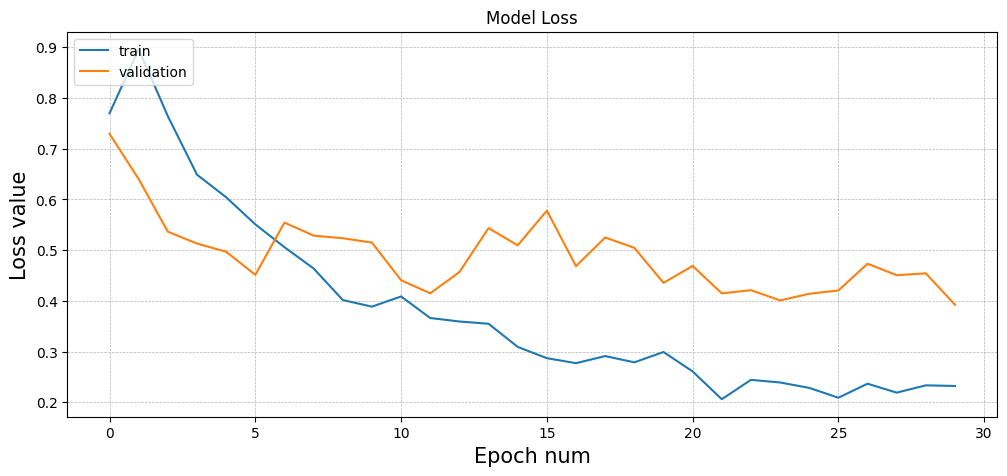

In [104]:
plt.rcParams['figure.figsize'] = (12, 5)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

#### Предсказание модели

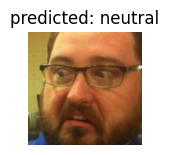

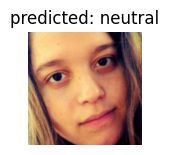

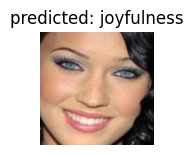

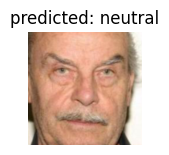

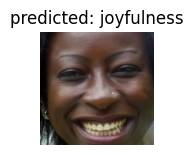

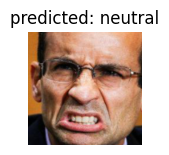

In [101]:
visualize_model(model)

plt.ioff()
plt.show()

#### Оценка работы модели

F1-Score macro:  0.517616816518859
F1-Score micro:  0.6289308176100629
F1-Score weighted:  0.5729370663015241
[  0.          32.35294118  55.          82.05128205 100.        ]


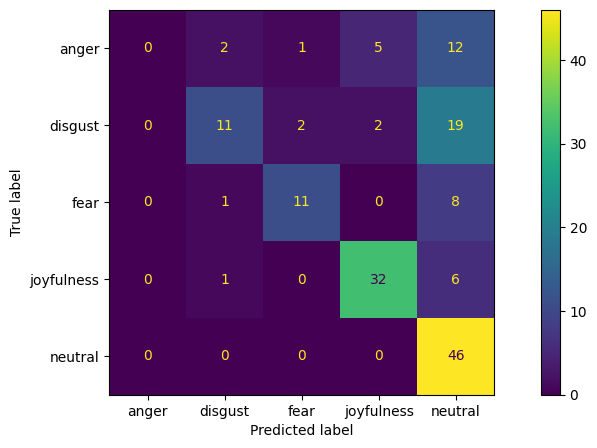

In [102]:
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

### Ignite

Пример работы высокоуровневой надстройки над PyTorch - Ignite

In [105]:
!pip install pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 KB 5.9 MB/s eta 0:00:00


In [106]:
!pip install --pre pytorch-ignite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [107]:
model_ignite = timm.create_model('efficientnet_b0', pretrained=True)

model_ignite.classifier = nn.Sequential(
           nn.Linear(1280, 256),
           nn.ReLU(),
           nn.Linear(256, len(class_names)))

model_ignite = model_ignite.to(device)
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model_ignite.parameters(), lr=CFG.lr) 

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

In [108]:
from ignite.engine import Engine, _prepare_batch
scaler = torch.cuda.amp.GradScaler()

def process_function(engine, batch):
    model_ignite.train()
    torch.set_grad_enabled(True)
    optimizer.zero_grad()
    x, y = _prepare_batch(batch, device=device)
    y_pred = model_ignite(x)
    loss = criterion(y_pred, y)
    #loss.backward()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    #optimizer.step()
    return loss.item()

trainer = Engine(process_function)

In [109]:
from ignite.engine import Events

log_interval = len(image_datasets['train'])

@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iteration = (engine.state.iteration - 1) % len(image_datasets['train']) + 1
    if iteration % log_interval == 0:
        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"
              .format(engine.state.epoch, 
                         iteration, 
                         len(image_datasets['train']), 
                         engine.state.output))

In [110]:
from ignite.engine import Engine
from ignite.metrics import Accuracy, Precision, Recall, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar

In [111]:
metrics = {
    'avg_accuracy': Accuracy(),
    'avg_precision': Precision(average=True),
    'avg_recall': Recall(average=True),
    'Loss': Loss(criterion)
    
}

In [112]:
from ignite.engine import create_supervised_evaluator

# Напомним, что device = “cuda” был определен выше
train_evaluator = create_supervised_evaluator(model_ignite, metrics=metrics, device=device)
pbar = ProgressBar()
pbar.attach(trainer)
val_evaluator = create_supervised_evaluator(model_ignite, metrics=metrics, device=device)
training_history = {'avg_accuracy':[],'Loss':[]}
validation_history = {'avg_accuracy':[],'Loss':[]}
last_epoch = []

In [113]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'Loss')

In [114]:
import numpy as np
from torch.utils.data.dataset import Subset

indices = np.arange(len(image_datasets['train']))
random_indices = np.random.permutation(indices)[:len(image_datasets['validation'])]
train_subset = Subset(image_datasets['train'], indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=CFG.batch_size, shuffle=True,
                                num_workers=CFG.num_workers, 
                                drop_last=True, pin_memory=device)

In [115]:
@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch
    print("Compute train metrics...")
    metrics = train_evaluator.run(train_eval_loader).metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['Loss']
    last_epoch.append(0)
    training_history['avg_accuracy'].append(accuracy)
    training_history['Loss'].append(loss)
    print("Training Results - Epoch: {}  Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | Loss: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      metrics['Loss']
                      ))

@trainer.on(Events.EPOCH_COMPLETED)
def compute_and_display_val_metrics(engine):
    epoch = engine.state.epoch
    print("Compute validation metrics...")
    metrics = val_evaluator.run(train_eval_loader).metrics
    accuracy = metrics['avg_accuracy']*100
    loss = metrics['Loss']
    last_epoch.append(0)
    training_history['avg_accuracy'].append(accuracy)
    training_history['Loss'].append(loss)
    print("Validation Results - Epoch: {}  Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | Loss: {:.4f}"
          .format(engine.state.epoch, 
                      metrics['avg_accuracy'], 
                      metrics['avg_precision'], 
                      metrics['avg_recall'],
                      metrics['Loss']
                      ))

In [116]:
from ignite.handlers import Timer, BasicTimeProfiler
basic_profiler = BasicTimeProfiler()
basic_profiler.attach(trainer)
trainer = trainer.run(train_eval_loader, max_epochs=30)

[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 1  Accuracy: 0.3553 | Precision: 0.1376 | Recall: 0.2458 | Loss: 1.5552
Compute validation metrics...
Validation Results - Epoch: 1  Accuracy: 0.3289 | Precision: 0.2267 | Recall: 0.2323 | Loss: 1.5653


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 2  Accuracy: 0.4211 | Precision: 0.4636 | Recall: 0.3120 | Loss: 1.4618
Compute validation metrics...
Validation Results - Epoch: 2  Accuracy: 0.4211 | Precision: 0.4706 | Recall: 0.3171 | Loss: 1.4731


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 3  Accuracy: 0.4539 | Precision: 0.7396 | Recall: 0.3692 | Loss: 1.3559
Compute validation metrics...
Validation Results - Epoch: 3  Accuracy: 0.4803 | Precision: 0.7631 | Recall: 0.3771 | Loss: 1.3523


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 4  Accuracy: 0.5329 | Precision: 0.5907 | Recall: 0.4437 | Loss: 1.2178
Compute validation metrics...
Validation Results - Epoch: 4  Accuracy: 0.5592 | Precision: 0.7634 | Recall: 0.4760 | Loss: 1.2171


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 5  Accuracy: 0.6908 | Precision: 0.7141 | Recall: 0.6258 | Loss: 1.0663
Compute validation metrics...
Validation Results - Epoch: 5  Accuracy: 0.6908 | Precision: 0.7272 | Recall: 0.6141 | Loss: 1.0649


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 6  Accuracy: 0.7434 | Precision: 0.7755 | Recall: 0.6998 | Loss: 0.8996
Compute validation metrics...
Validation Results - Epoch: 6  Accuracy: 0.7303 | Precision: 0.7646 | Recall: 0.6823 | Loss: 0.9012


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 7  Accuracy: 0.7961 | Precision: 0.7955 | Recall: 0.7576 | Loss: 0.8504
Compute validation metrics...
Validation Results - Epoch: 7  Accuracy: 0.7829 | Precision: 0.7612 | Recall: 0.7356 | Loss: 0.8484


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 8  Accuracy: 0.8618 | Precision: 0.8585 | Recall: 0.8369 | Loss: 0.6631
Compute validation metrics...
Validation Results - Epoch: 8  Accuracy: 0.8421 | Precision: 0.8211 | Recall: 0.8092 | Loss: 0.7160


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 9  Accuracy: 0.8421 | Precision: 0.8258 | Recall: 0.8150 | Loss: 0.6106
Compute validation metrics...
Validation Results - Epoch: 9  Accuracy: 0.8355 | Precision: 0.8371 | Recall: 0.8061 | Loss: 0.5727


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 10  Accuracy: 0.8750 | Precision: 0.8610 | Recall: 0.8777 | Loss: 0.5834
Compute validation metrics...
Validation Results - Epoch: 10  Accuracy: 0.8750 | Precision: 0.8451 | Recall: 0.8580 | Loss: 0.5008


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 11  Accuracy: 0.9079 | Precision: 0.8961 | Recall: 0.8805 | Loss: 0.4433
Compute validation metrics...
Validation Results - Epoch: 11  Accuracy: 0.9145 | Precision: 0.9005 | Recall: 0.9031 | Loss: 0.4091


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 12  Accuracy: 0.9474 | Precision: 0.9460 | Recall: 0.9403 | Loss: 0.3930
Compute validation metrics...
Validation Results - Epoch: 12  Accuracy: 0.9276 | Precision: 0.9128 | Recall: 0.9158 | Loss: 0.4083


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 13  Accuracy: 0.9145 | Precision: 0.9109 | Recall: 0.9139 | Loss: 0.3418
Compute validation metrics...
Validation Results - Epoch: 13  Accuracy: 0.9145 | Precision: 0.9155 | Recall: 0.9078 | Loss: 0.3823


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 14  Accuracy: 0.8947 | Precision: 0.8868 | Recall: 0.8842 | Loss: 0.3596
Compute validation metrics...
Validation Results - Epoch: 14  Accuracy: 0.9408 | Precision: 0.9449 | Recall: 0.9304 | Loss: 0.2694


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 15  Accuracy: 0.9474 | Precision: 0.9399 | Recall: 0.9462 | Loss: 0.2150
Compute validation metrics...
Validation Results - Epoch: 15  Accuracy: 0.9671 | Precision: 0.9571 | Recall: 0.9718 | Loss: 0.1904


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 16  Accuracy: 0.9276 | Precision: 0.9391 | Recall: 0.9135 | Loss: 0.3021
Compute validation metrics...
Validation Results - Epoch: 16  Accuracy: 0.8882 | Precision: 0.9012 | Recall: 0.8946 | Loss: 0.3446


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 17  Accuracy: 0.9539 | Precision: 0.9551 | Recall: 0.9472 | Loss: 0.2185
Compute validation metrics...
Validation Results - Epoch: 17  Accuracy: 0.9408 | Precision: 0.9357 | Recall: 0.9262 | Loss: 0.2131


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 18  Accuracy: 0.9408 | Precision: 0.9317 | Recall: 0.9454 | Loss: 0.2413
Compute validation metrics...
Validation Results - Epoch: 18  Accuracy: 0.9408 | Precision: 0.9421 | Recall: 0.9346 | Loss: 0.1995


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 19  Accuracy: 0.9145 | Precision: 0.9111 | Recall: 0.9065 | Loss: 0.2581
Compute validation metrics...
Validation Results - Epoch: 19  Accuracy: 0.9211 | Precision: 0.9165 | Recall: 0.8997 | Loss: 0.2420


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 20  Accuracy: 0.9408 | Precision: 0.9421 | Recall: 0.9361 | Loss: 0.1808
Compute validation metrics...
Validation Results - Epoch: 20  Accuracy: 0.9671 | Precision: 0.9689 | Recall: 0.9596 | Loss: 0.1352


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 21  Accuracy: 0.9408 | Precision: 0.9419 | Recall: 0.9354 | Loss: 0.1674
Compute validation metrics...
Validation Results - Epoch: 21  Accuracy: 0.9539 | Precision: 0.9581 | Recall: 0.9462 | Loss: 0.1569


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 22  Accuracy: 0.9474 | Precision: 0.9503 | Recall: 0.9448 | Loss: 0.1496
Compute validation metrics...
Validation Results - Epoch: 22  Accuracy: 0.9737 | Precision: 0.9668 | Recall: 0.9719 | Loss: 0.1030


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 23  Accuracy: 0.9605 | Precision: 0.9544 | Recall: 0.9580 | Loss: 0.1249
Compute validation metrics...
Validation Results - Epoch: 23  Accuracy: 0.9474 | Precision: 0.9529 | Recall: 0.9477 | Loss: 0.1810


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 24  Accuracy: 0.9605 | Precision: 0.9641 | Recall: 0.9587 | Loss: 0.1424
Compute validation metrics...
Validation Results - Epoch: 24  Accuracy: 0.9539 | Precision: 0.9670 | Recall: 0.9534 | Loss: 0.1236


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 25  Accuracy: 0.9605 | Precision: 0.9524 | Recall: 0.9497 | Loss: 0.0910
Compute validation metrics...
Validation Results - Epoch: 25  Accuracy: 0.9342 | Precision: 0.9305 | Recall: 0.9249 | Loss: 0.1674


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 26  Accuracy: 0.9342 | Precision: 0.9276 | Recall: 0.9280 | Loss: 0.1492
Compute validation metrics...
Validation Results - Epoch: 26  Accuracy: 0.9342 | Precision: 0.9273 | Recall: 0.9232 | Loss: 0.1740


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 27  Accuracy: 0.9408 | Precision: 0.9414 | Recall: 0.9510 | Loss: 0.1697
Compute validation metrics...
Validation Results - Epoch: 27  Accuracy: 0.9737 | Precision: 0.9825 | Recall: 0.9684 | Loss: 0.1107


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 28  Accuracy: 0.9671 | Precision: 0.9731 | Recall: 0.9563 | Loss: 0.1350
Compute validation metrics...
Validation Results - Epoch: 28  Accuracy: 0.9671 | Precision: 0.9604 | Recall: 0.9688 | Loss: 0.1320


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 29  Accuracy: 0.9276 | Precision: 0.9259 | Recall: 0.9251 | Loss: 0.1907
Compute validation metrics...
Validation Results - Epoch: 29  Accuracy: 0.9605 | Precision: 0.9546 | Recall: 0.9666 | Loss: 0.1598


[1/19]   5%|5          [00:00<?]

Compute train metrics...
Training Results - Epoch: 30  Accuracy: 0.9737 | Precision: 0.9681 | Recall: 0.9818 | Loss: 0.1223
Compute validation metrics...
Validation Results - Epoch: 30  Accuracy: 0.9803 | Precision: 0.9795 | Recall: 0.9824 | Loss: 0.1186


#### Оценка работы модели

F1-Score macro:  0.6404839113249248
F1-Score micro:  0.660377358490566
F1-Score weighted:  0.6612206920016609
[45.         52.94117647 75.         76.92307692 71.73913043]


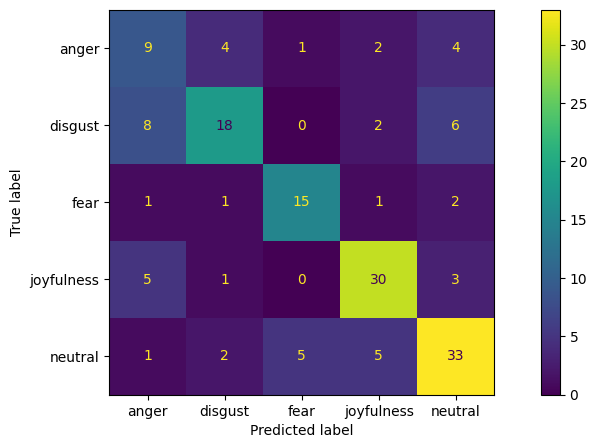

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['validation']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ignite(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])


print('F1-Score macro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='macro'))
print('F1-Score micro: ',f1_score(lbllist.numpy(), predlist.numpy(), average='micro'))
print('F1-Score weighted: ',f1_score(lbllist.numpy(), predlist.numpy(), average='weighted'))
# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
# print(conf_mat)
print('========================================================')

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
disp.plot()
plt.show()

# <b>2.2. TensorFlow</b>

## <b>Предварительные замечания</b>

### О выбранной тактике обучения моделей

В данной работе представлены две модели, реализованные инструментами библиотеки TensorFlow. Обе модели обучены на предобученных моделях, которые используются для задачи классификации изображений - `InceptionV3` и `MobileNetV2` (обе обучены на базе данных ImageNet). Подробно о моделях можно прочитать в специальных статьях, ссылки на которые приведены ниже.

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:

- с использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации, однако у него есть существенный для разработчика недостаток - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (то есть мы имеем дело с семействами моделей). Также два способа отличаются методом `rescale` - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение.

Мы используем второй способ, так как он гораздо более пластичен для тонкой настройки и позволяет экспериментировать с гиперпараметрами.

Всего для подотовки дипломного проекта было использовано четыре различных предобученных модели с использованием различных оптимизаторов (`SGD`, `RMSprop`, `Adam`) и функций потерь (`mse`, `categorical crossentropy`), лучшие параметры были определены в ходе ряда экспериментов. С большей частью экспериментов можно ознакомиться по [ссылке](https://github.com/lefthand67/SBER_Diploma/tree/main/experiments) (подробных словесных описаний на данный момент нет, но названия и подписи говорят сами за себя).

В данной работе представлены модели, построенные на связке `RMSprop/mse`, как показавшие себя с лучшей стороны. Также эксперименты показали, что данный датасет с данной связкой optimizer/loss повышает эффективность обучения при добавлении в слой классификации регуляризатора Ridge Regression (`L2`) со степенью 0.5 (эксперименты проведены на созданной с нуля нейросети, без предобученной модели). Для снижения вероятности переобучения добавлены слои аугментации и слой `dropout` (степень 0.2). 

Архитектура представленных в работе моделей отличается минимализмом - отсутствуют слои свертки и дополнительные полносвязные слои перед классификатором, так как на экспериментах данные опыты дали результат хуже базовых моделей ([эксперименты](https://github.com/lefthand67/SBER_Diploma/blob/main/experiments/01_tf_pretrained_InceptionResNetV2.ipynb) проводились на предобученной модели `InceptionResNetV2`).

Обучение представленных моделей происходило в два этапа: 
- сначала обучается классификатор на базе предобученной модели, у которой отключены верхние слои (include_top=False),
- затем мы размораживаем часть слоев предобученной модели и дообучаем наш классификатор.

Рассмотрим эти этапы подробнее.

### `feature_extractor` и `bottleneck layer`

На первом этапе создается `feature_extractor`, который извлекает веса из предобученной модели для переноса обучения на нашу модель. При переносе обучения рекомендуется отключать самые "верхние", то есть последние слои, вплоть до самого последнего перед слоем `Flatten` предобученной модели: именно в них происходит обучение на данную классификацию, в то время как мы собираемся строить свой классификатор. Самый последний слой перед `Flatten` содержит самые  общие признаки изображений (в литературе его называют слоем "бутылочное горлышко" - "bottleneck layer"), именно поэтому он представляет для нас наибольшую ценность. Данная задача решается отключением аргмуента `include_top` и добавлением слоя `Flatten` для перевода тензора изображений в векторный вид (или можно просто активировать аргумент `pooling` внутри самого `feature_extractor`). 

### Разморозка слоев

За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения (в первых двух блоках он установлен в режим `False`). В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор c отключенным режимом `training`, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена. Кроме того, в общем случае нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений, тогда как цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете (тем не менее в модели с использованием MobileNetV2 мы разморозим все слои ввиду минималистичности данной предобученной модели, специально разработанной для переносных устройств).

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение, используемые для нормализации текущего батча. Запустив модель в режиме `training=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть (`feature_extractor.trainable=True`), слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

## <b>Модель 2.2.1</b> | InceptionV3 

Authors: Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna

https://arxiv.org/abs/1512.00567

### Модуль `tf.keras.applications` | `feature_extractor_layer`

Создаем `feature_extractor` для обучения классификатора. 

In [45]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.InceptionV3(
                                                include_top=False,
                                                weights="imagenet",
                                                input_shape=IMG_SHAPE
)
feature_extractor.trainable = do_fine_tuning

87910968/87910968 [==============================] - 3s 0us/step


### Архитектура модели

In [46]:
from tensorflow.keras import layers

REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='InceptionV3_based')

model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 batch_normalization_94 (Bat  (None, 131072)     

Посморим на количество переменных, которые будут обучаться в данной архитектуре.

In [47]:
len(model.trainable_variables)

4

### Компиляция

In [48]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [49]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 26s 347ms/step - loss: 14.9156 - accuracy: 0.2111 - PR_AUC: 0.2057 - val_loss: 8.7523 - val_accuracy: 0.1509 - val_PR_AUC: 0.1801 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 7s 220ms/step - loss: 9.6311 - accuracy: 0.1991 - PR_AUC: 0.2024 - val_loss: 7.3368 - val_accuracy: 0.1950 - val_PR_AUC: 0.1974 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 7s 215ms/step - loss: 9.1896 - accuracy: 0.1741 - PR_AUC: 0.1908 - val_loss: 5.9951 - val_accuracy: 0.1698 - val_PR_AUC: 0.1978 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 7s 219ms/step - loss: 9.4130 - accuracy: 0.1861 - PR_AUC: 0.1936 - val_loss: 12.8861 - val_accuracy: 0.1761 - val_PR_AUC: 0.1897 - lr: 0.0100
Epoch 5/500
34/34 [==============================] - 7s 208ms/step - loss: 6.8855 - accuracy: 0.2176 - PR_AUC: 0.2084 - val_loss: 9.1384 - val_accuracy: 0.1572 - val_PR_AUC: 0.1840 - lr: 0.0085
Epoch 6/500
34/34 [========

### Визуализация данных по работе алгоритма

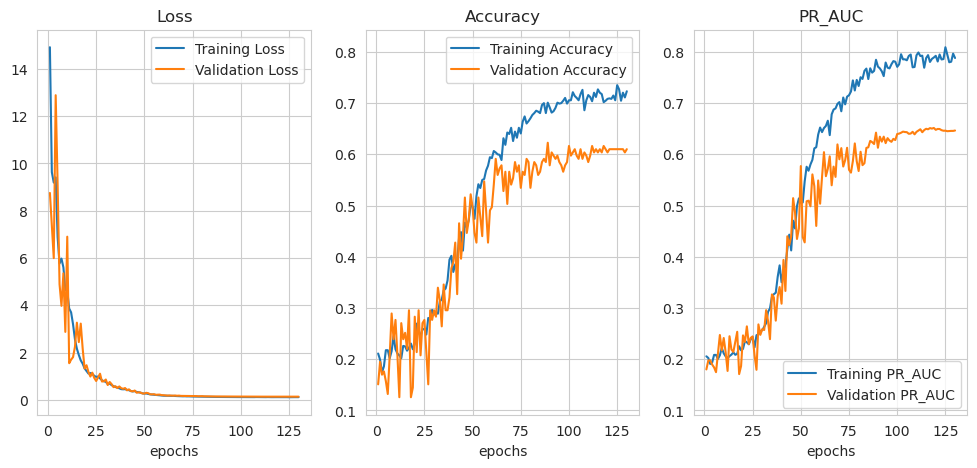

In [50]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [51]:
show_predictions(model, test_batches, visualization=False)

joyfulness is joyfulness (66.61%)
neutral is neutral (81.76%)
anger is neutral (44.32%)
neutral is neutral (39.82%)
neutral is neutral (49.58%)
fear is fear (47.31%)
neutral is neutral (73.20%)
anger is joyfulness (51.92%)
neutral is neutral (60.25%)
disgust is disgust (84.36%)


### Матрица ошибок

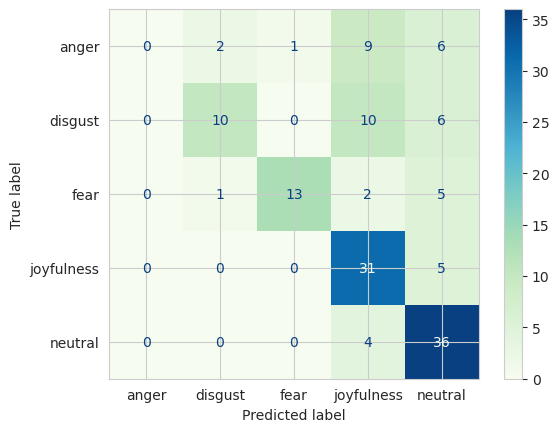

In [52]:
confusion_matrix(model, test_batches)

### Вывод

In [53]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.62
val_PR_AUC: 0.65


In [54]:
# сохраним данные о модели
model_221 = model
hist_221 = hist
model_221_best_results = model_best_results

## Разморозка слоев

Второй этап - дообучение нашего классификатора.

In [55]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


In [56]:
# с какого слоя мы размораживаем модель
fine_tune_at = int(len(feature_extractor.layers)/2)

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [57]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  311
Trainable variables in the feature extractor:  92


При желании можно посмотреть на архитектуру `feature_extractor`.

In [58]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы внесенные изменения были применены. Уменьшим базовый lr, чтобы избежать быстрого переобучения модели.

In [59]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [60]:
model.summary()

Model: "InceptionV3_based"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 batch_normalization_94 (Bat  (None, 131072)     

In [61]:
len(model.trainable_variables)

96

### Обучение

In [62]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 29s 334ms/step - loss: 0.1881 - accuracy: 0.5898 - PR_AUC: 0.6256 - val_loss: 0.2094 - val_accuracy: 0.5220 - val_PR_AUC: 0.6184 - lr: 1.0000e-04
Epoch 2/500
34/34 [==============================] - 9s 277ms/step - loss: 0.1543 - accuracy: 0.6843 - PR_AUC: 0.7524 - val_loss: 0.1815 - val_accuracy: 0.5597 - val_PR_AUC: 0.6869 - lr: 1.0000e-04
Epoch 3/500
34/34 [==============================] - 10s 287ms/step - loss: 0.1355 - accuracy: 0.7398 - PR_AUC: 0.8107 - val_loss: 0.1425 - val_accuracy: 0.7170 - val_PR_AUC: 0.7977 - lr: 1.0000e-04
Epoch 4/500
34/34 [==============================] - 9s 276ms/step - loss: 0.1225 - accuracy: 0.7611 - PR_AUC: 0.8385 - val_loss: 0.1231 - val_accuracy: 0.7358 - val_PR_AUC: 0.8380 - lr: 1.0000e-04
Epoch 5/500
34/34 [==============================] - 9s 271ms/step - loss: 0.1135 - accuracy: 0.7741 - PR_AUC: 0.8555 - val_loss: 0.1478 - val_accuracy: 0.6792 - val_PR_AUC: 0.7491 - lr: 1.0000e-04
Epoch 6/

### Визуализация данных по работе алгоритма

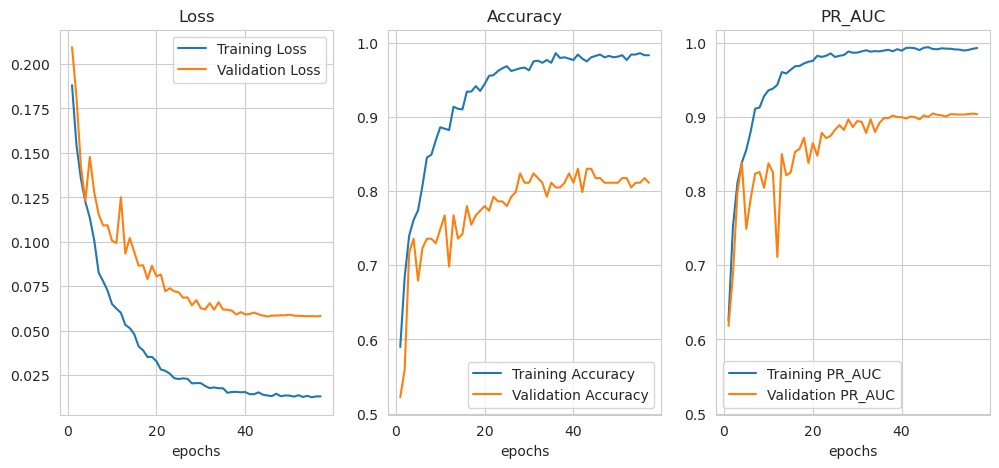

In [63]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

In [64]:
show_predictions(model, test_batches, visualization=False)

neutral is neutral (99.97%)
neutral is neutral (98.83%)
joyfulness is joyfulness (96.29%)
fear is fear (95.23%)
disgust is disgust (98.33%)
joyfulness is joyfulness (99.58%)
anger is anger (95.89%)
anger is neutral (73.04%)
neutral is anger (62.06%)
neutral is neutral (98.14%)


### Матрица ошибок

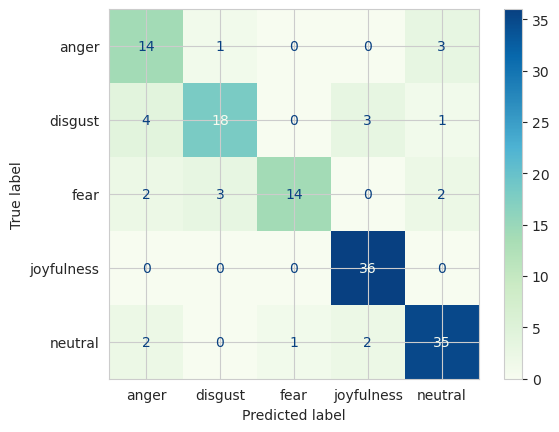

In [65]:
confusion_matrix(model, test_batches)

### Вывод

In [66]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.83
val_PR_AUC: 0.9


Итак, данная модель достигла минимальной цели в 80% и значительно ее превзошла.

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [67]:
EMOTIONS_INCEPTIONV3_SAVED_MODEL = "./saved/inceptionv3_saved_model"
tf.saved_model.save(model, EMOTIONS_INCEPTIONV3_SAVED_MODEL)

Сохраним также названия классов.

In [68]:
with open('./saved/labels.txt', 'w', encoding="utf-8") as f:
    f.write('\n'.join(class_names))

## <b>Модель 2.2.2</b> | MobileNetV2

Authors: Mark Sandler, Andrew Howard, Menglong Zhu, Andrey Zhmoginov, Liang-Chieh Chen

https://arxiv.org/abs/1801.04381

### Новый `tf.dataset`

Для следующей модели нам потребуется заново создать `tf.dataset` под то разрешение изображений, которое используется в MobileNetV2 - (224, 224). 

In [69]:
train_batches, validation_batches, test_batches = datasets_prep(image_size=(224, 224))

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


### Модуль `tf.keras.applications` | `feature_extractor_layer`

Теперь повторим все шаги, которые мы проделывали для предыдущей модели.

In [70]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

9406464/9406464 [==============================] - 0s 0us/step


### Архитектура модели

In [71]:
from tensorflow.keras import layers

strides = 2
REGULARIZER=tf.keras.regularizers.L1L2(l1=0.0, l2=0.5)

inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = rescale(inputs)
x = data_aug(x)
x = feature_extractor(x, training=False)

x = layers.Flatten()(x)

x = layers.Dropout(DROPOUT_RATE)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation='softmax',
                       kernel_regularizer=REGULARIZER
                       )(x)
model = tf.keras.Model(inputs, outputs,
                       name='MobileNetV2_RMSprop_mse')

model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_1 (Dropout)         (None, 128000)            0         
                                           

In [72]:
len(model.trainable_variables)

4

### Компиляция

In [73]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR),
              loss='mse',
              metrics=metrics)

### Обучение модели

In [74]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 16s 279ms/step - loss: 14.6224 - accuracy: 0.1963 - PR_AUC: 0.2291 - val_loss: 14.3040 - val_accuracy: 0.1887 - val_PR_AUC: 0.1891 - lr: 0.0100
Epoch 2/500
34/34 [==============================] - 8s 235ms/step - loss: 9.2835 - accuracy: 0.2111 - PR_AUC: 0.2066 - val_loss: 13.0247 - val_accuracy: 0.2767 - val_PR_AUC: 0.2329 - lr: 0.0100
Epoch 3/500
34/34 [==============================] - 9s 245ms/step - loss: 9.9459 - accuracy: 0.2463 - PR_AUC: 0.2239 - val_loss: 13.1503 - val_accuracy: 0.1824 - val_PR_AUC: 0.1882 - lr: 0.0100
Epoch 4/500
34/34 [==============================] - 8s 227ms/step - loss: 7.3771 - accuracy: 0.2176 - PR_AUC: 0.2116 - val_loss: 5.1045 - val_accuracy: 0.2642 - val_PR_AUC: 0.2323 - lr: 0.0085
Epoch 5/500
34/34 [==============================] - 8s 225ms/step - loss: 7.5584 - accuracy: 0.2037 - PR_AUC: 0.2031 - val_loss: 8.2595 - val_accuracy: 0.2201 - val_PR_AUC: 0.2061 - lr: 0.0085
Epoch 6/500
34/34 [======

### Визуализация данных по работе алгоритма

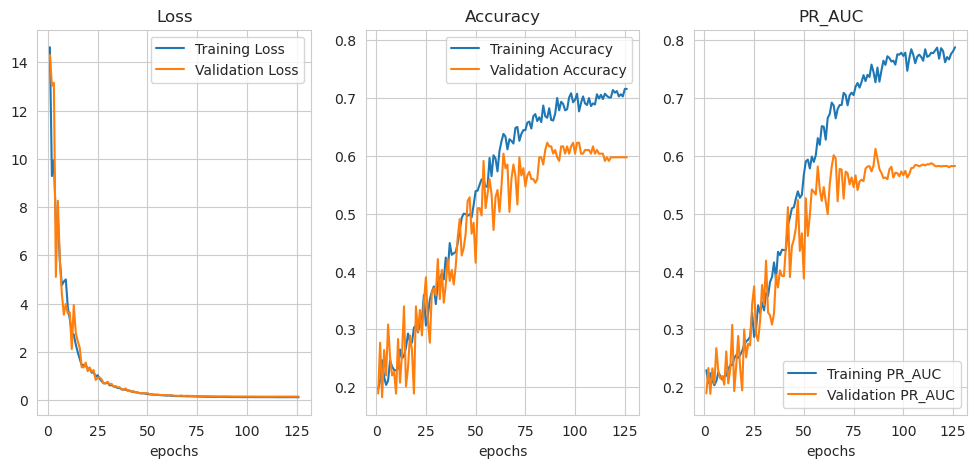

In [75]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

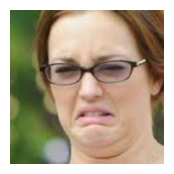

disgust is neutral (30.85%)


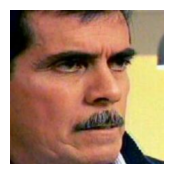

anger is neutral (57.72%)


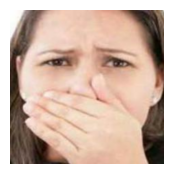

disgust is disgust (60.68%)


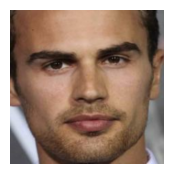

neutral is neutral (82.10%)


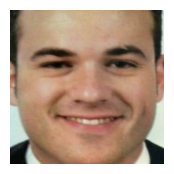

joyfulness is neutral (52.38%)


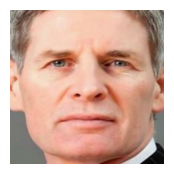

neutral is neutral (70.09%)


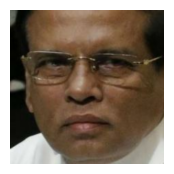

neutral is neutral (72.23%)


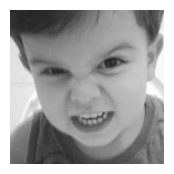

anger is joyfulness (50.97%)


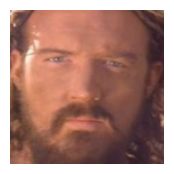

neutral is neutral (60.32%)


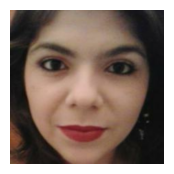

neutral is neutral (66.22%)


In [76]:
show_predictions(model, test_batches, visualization=True)

### Матрица ошибок

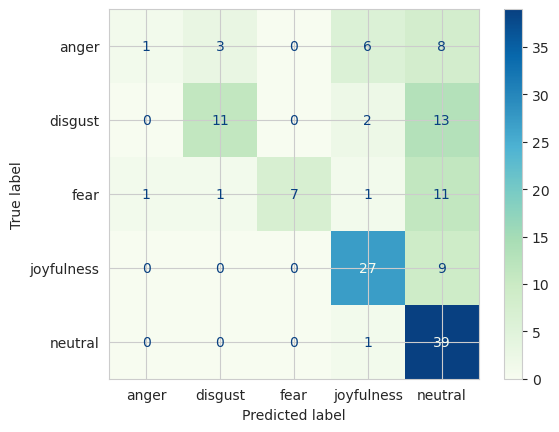

In [77]:
confusion_matrix(model, test_batches)

### Вывод

In [78]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.62
val_PR_AUC: 0.61


In [79]:
# сохраним данные о модели
model_222 = model
hist_222 = hist
model_222_best_results = model_best_results

## Разморозка слоев

In [80]:
do_fine_tuning = True
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


На этот раз разморозим все слои.

In [81]:
# с какого слоя мы размораживаем модель
fine_tune_at = 0

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at+1]:
    layer.trainable = False

Посмотрим на общее количество слоев в предобученной модели, а также на количество переменных, которые будут обучаться в размороженных слоях. 

In [82]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable variables in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable variables in the feature extractor:  156


При желании можно посмотреть на архитектуру `feature_extractor`.

In [83]:
# feature_extractor.summary()

### Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены. Уменьшим базовый lr, чтобы избежать переобучения нашй уже обученной модели.

In [84]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=BASE_LR/100),
              loss='mse',
              metrics=metrics)

### Архитектура модели

In [85]:
model.summary()

Model: "MobileNetV2_RMSprop_mse"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 128000)            0         
                                                                 
 dropout_1 (Dropout)         (None, 128000)            0         
                                           

In [86]:
len(model.trainable_variables)

160

### Обучение

In [87]:
hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 callbacks=[early_stopping, lr_schedule])

Epoch 1/500
34/34 [==============================] - 37s 395ms/step - loss: 0.1916 - accuracy: 0.4907 - PR_AUC: 0.5181 - val_loss: 0.2034 - val_accuracy: 0.4906 - val_PR_AUC: 0.4863 - lr: 1.0000e-04
Epoch 2/500
34/34 [==============================] - 12s 344ms/step - loss: 0.1662 - accuracy: 0.5787 - PR_AUC: 0.6067 - val_loss: 0.1762 - val_accuracy: 0.5472 - val_PR_AUC: 0.5322 - lr: 1.0000e-04
Epoch 3/500
34/34 [==============================] - 12s 345ms/step - loss: 0.1559 - accuracy: 0.5926 - PR_AUC: 0.6510 - val_loss: 0.1633 - val_accuracy: 0.6101 - val_PR_AUC: 0.6457 - lr: 1.0000e-04
Epoch 4/500
34/34 [==============================] - 13s 362ms/step - loss: 0.1516 - accuracy: 0.6157 - PR_AUC: 0.6689 - val_loss: 0.1814 - val_accuracy: 0.5220 - val_PR_AUC: 0.5702 - lr: 1.0000e-04
Epoch 5/500
34/34 [==============================] - 12s 342ms/step - loss: 0.1445 - accuracy: 0.6250 - PR_AUC: 0.6827 - val_loss: 0.1991 - val_accuracy: 0.4277 - val_PR_AUC: 0.4977 - lr: 8.5000e-05
Epoch

### Визуализация данных по работе алгоритма

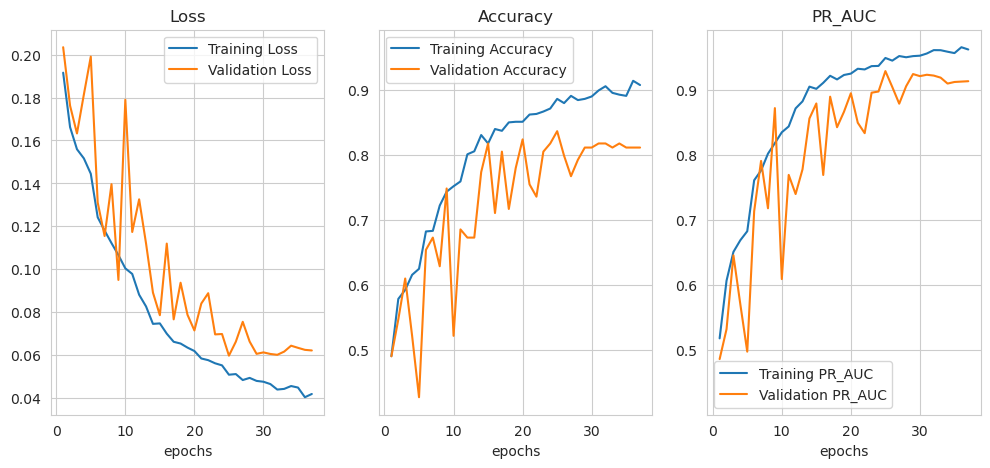

In [88]:
val_acc_viz(hist, len(hist.history['accuracy']))

### Предсказание модели

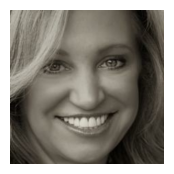

joyfulness is joyfulness (99.48%)


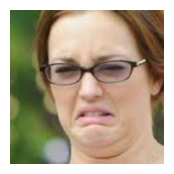

disgust is disgust (98.86%)


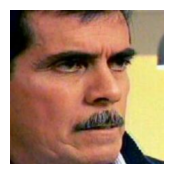

anger is neutral (85.34%)


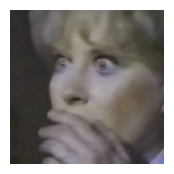

fear is anger (45.89%)


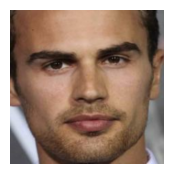

neutral is neutral (99.67%)


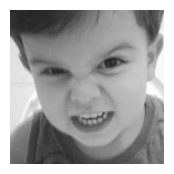

anger is joyfulness (69.54%)


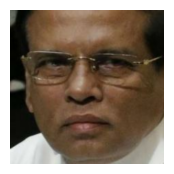

neutral is neutral (88.59%)


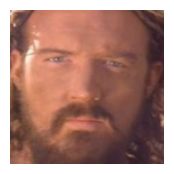

neutral is neutral (79.75%)


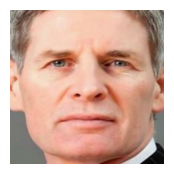

neutral is neutral (92.22%)


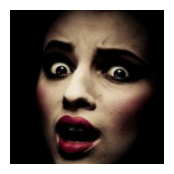

fear is anger (55.22%)


In [89]:
show_predictions(model, test_batches, visualization=True)

### Матрица ошибок

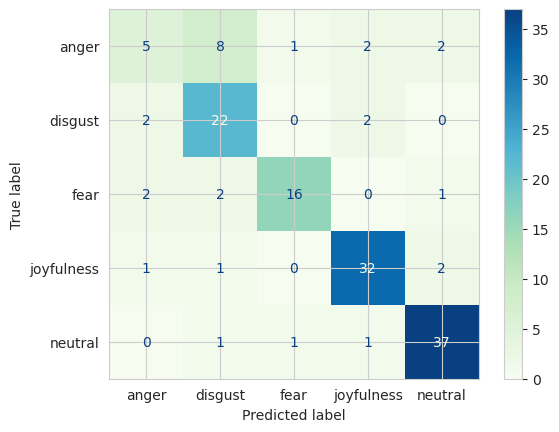

In [90]:
confusion_matrix(model, test_batches)

### Вывод

In [91]:
val_acc_best = np.max(hist.history['val_accuracy'])
val_auc_best = np.max(hist.history['val_PR_AUC'])
model_best_results = round(val_acc_best, 2), round(val_auc_best, 2)

print(f'val_accuracy: {model_best_results[0]}')
print(f'val_PR_AUC: {model_best_results[1]}')

val_accuracy: 0.84
val_PR_AUC: 0.93


Данная модель также превзошла цель в 80%. Как видно из предсказаний на конкретных изображениях, модель путается с гневом и страхом, именно эти изображения представлены в количестве менее 200 штук. Таким образом, для дальнейшего улучшения качества модели следует, в первую очередь, обратить внимание на улучшение самого датасета: увеличить общее количество изображений и желательно сбалансировать классы.  

### Сохранение модели

Сохраним обученную модель на случай, если нам придется ее использовать в дальнейшем.

In [92]:
EMOTIONS_MOBILENETV2_SAVED_MODEL = "./saved/momobilenetv2_saved_model"
tf.saved_model.save(model, EMOTIONS_MOBILENETV2_SAVED_MODEL)

# <b>2.3. Scikit-learn</b>

## <b>Модель 2.3.1 | RandomForestClassifier</b>

"Случайный лес" с сокращением размерности признаков и нормализацией данных. 

Для реализации алгоритма случайного леса с сокращением размерности признаков и нормализацией данных мы будем использовать метод SelectFromModel из библиотеки scikit-learn. 

Мы будем использовать некое базовое количество признаков, а с помощью метода SelectFromModel сможем автоматически отобрать оптимальное количество признаков для обучения модели. 

### Сплит датасета

In [ ]:
# Разделим данные на признаки и метки
y = final_df[150528]
X = final_df.drop(columns=[150528])


In [ ]:
# Разобьём данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Подготовка модели

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [ ]:
# Создаем объект для случайного леса
rf_classifier = RandomForestClassifier()

In [ ]:
# Описываем пайплайн для автоматической настройки числа признаков
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(estimator=rf_classifier)),
    ('classification', rf_classifier),
])

In [ ]:
# Определяем диапазон базового количества признаков
min_features = 2
max_features = 1000

In [ ]:
# Определяем параметры для подбора оптимального числа базовых признаков и гиперпараметров деревьев
param_grid = {
    'feature_selection__threshold': ['mean', 'median', '1.25*mean'],
    'classification__n_estimators': [10, 50, 100],
    'classification__max_depth': [10, 20, 30],
}

### Обучение модели

In [ ]:
# Применяем кросс-валидацию для нахождения оптимальных параметров
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier())),
                                       ('classification',
                                        RandomForestClassifier())]),
             param_grid={'classification__max_depth': [10, 20, 30],
                         'classification__n_estimators': [10, 50, 100],
                         'feature_selection__threshold': ['mean', 'median',
                                                          '1.25*mean']})

In [ ]:
# Получаем оптимальный классификатор
optimized_rf_classifier = grid_search.best_estimator_

In [ ]:
optimized_rf_classifier

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='1.25*mean')),
                ('classification', RandomForestClassifier(max_depth=30))])

### Оценка работы модели

In [ ]:
# Прогнозируем значения на тестовом наборе данных
y_pred = optimized_rf_classifier.predict(X_test)

In [ ]:
y_test

783    3
781    3
605    2
583    2
921    3
      ..
886    3
396    1
936    3
738    3
619    2
Name: 150528, Length: 343, dtype: int8

In [ ]:
y_pred

array([1, 3, 4, 4, 3, 4, 4, 3, 3, 3, 1, 0, 3, 3, 2, 3, 4, 2, 2, 4, 4, 4,
       3, 3, 1, 2, 3, 3, 4, 4, 4, 3, 1, 4, 4, 4, 0, 4, 2, 3, 4, 4, 4, 3,
       4, 3, 3, 4, 4, 1, 4, 4, 2, 3, 4, 1, 3, 1, 4, 3, 4, 4, 3, 4, 4, 4,
       3, 4, 3, 4, 1, 4, 4, 4, 1, 2, 4, 4, 4, 4, 4, 4, 3, 1, 4, 0, 3, 4,
       4, 3, 1, 4, 1, 4, 1, 2, 1, 2, 3, 4, 4, 4, 4, 1, 4, 3, 3, 3, 4, 3,
       4, 3, 4, 2, 4, 3, 1, 4, 1, 4, 1, 3, 4, 3, 3, 3, 1, 4, 3, 3, 4, 3,
       4, 4, 4, 3, 3, 3, 3, 4, 3, 1, 1, 1, 4, 1, 3, 1, 4, 3, 4, 4, 3, 4,
       1, 4, 4, 4, 1, 3, 1, 3, 3, 1, 4, 2, 1, 4, 4, 3, 1, 4, 4, 3, 1, 2,
       1, 3, 3, 3, 1, 4, 3, 3, 1, 4, 3, 4, 3, 2, 4, 1, 4, 2, 4, 1, 1, 4,
       4, 4, 3, 3, 3, 4, 3, 4, 4, 4, 4, 1, 4, 3, 3, 4, 4, 4, 3, 1, 4, 1,
       4, 2, 3, 3, 4, 4, 4, 4, 1, 4, 1, 4, 4, 1, 3, 0, 4, 4, 3, 0, 4, 4,
       3, 4, 3, 3, 3, 3, 4, 1, 3, 4, 4, 3, 2, 1, 3, 4, 4, 4, 4, 2, 4, 4,
       3, 1, 1, 3, 4, 4, 1, 4, 3, 3, 4, 3, 4, 1, 4, 3, 3, 2, 0, 4, 4, 4,
       3, 4, 4, 4, 3, 3, 4, 4, 3, 1, 2, 4, 2, 2, 0,

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Посчитаем точность модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)


# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
print('____________________________')
print("Precision (micro):", prec)
print("Recall (micro):", rec)
print("F1-score (micro):", f1)


# Вычисление точности, полноты и F1-меры 
prec = precision_score(y_test, y_pred, average=None)
rec = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print('____________________________')
print("Precision (None):", prec)
print("Recall (None):", rec)
print("F1-score (None):", f1)

Accuracy: 0.5131195335276968
Precision (macro): 0.5175410303981731
Recall (macro): 0.43463177171042344
F1-score (macro): 0.43779029300233124
____________________________
Precision (micro): 0.5131195335276968
Recall (micro): 0.5131195335276968
F1-score (micro): 0.5131195335276968
____________________________
Precision (None): [0.5        0.58181818 0.46153846 0.60204082 0.44230769]
Recall (None): [0.10810811 0.43243243 0.27272727 0.66292135 0.6969697 ]
F1-score (None): [0.17777778 0.49612403 0.34285714 0.63101604 0.54117647]


### Продолжение эксперимента

Попробуем увеличить диапазон признаков, а также максимальную глубину леса

In [ ]:
# Определяем диапазон базового количества признаков
min_features = 2
max_features = 5000

In [ ]:
# Определяем параметры для подбора оптимального числа базовых признаков и гиперпараметров деревьев
param_grid = {
    'feature_selection__threshold': ['mean', 'median', '1.25*mean'],
    'classification__n_estimators': [10, 500, 1000],
    'classification__max_depth': [10, 50, 100],
}

In [ ]:
# Применяем кросс-валидацию для нахождения оптимальных параметров
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RandomForestClassifier())),
                                       ('classification',
                                        RandomForestClassifier())]),
             param_grid={'classification__max_depth': [10, 50, 100],
                         'classification__n_estimators': [10, 500, 1000],
                         'feature_selection__threshold': ['mean', 'median',
                                                          '1.25*mean']})

In [ ]:
# Получаем оптимальный классификатор
optimized_rf_classifier = grid_search.best_estimator_

In [ ]:
optimized_rf_classifier

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(),
                                 threshold='median')),
                ('classification',
                 RandomForestClassifier(max_depth=50, n_estimators=1000))])

In [ ]:
# Прогнозируем значения на тестовом наборе данных
y_pred = optimized_rf_classifier.predict(X_test)

In [ ]:
# Посчитаем точность модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)


# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
print('____________________________')
print("Precision (micro):", prec)
print("Recall (micro):", rec)
print("F1-score (micro):", f1)


# Вычисление точности, полноты и F1-меры 
prec = precision_score(y_test, y_pred, average=None)
rec = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print('____________________________')
print("Precision (None):", prec)
print("Recall (None):", rec)
print("F1-score (None):", f1)

Accuracy: 0.5131195335276968
Precision (macro): 0.5731619562559146
Recall (macro): 0.4257658577883297
F1-score (macro): 0.42452619520777335
____________________________
Precision (micro): 0.5131195335276968
Recall (micro): 0.5131195335276968
F1-score (micro): 0.5131195335276968
____________________________
Precision (None): [0.75       0.60416667 0.47826087 0.58510638 0.44827586]
Recall (None): [0.08108108 0.39189189 0.25       0.61797753 0.78787879]
F1-score (None): [0.14634146 0.47540984 0.32835821 0.6010929  0.57142857]


## <b>Модель 2.3.2 | Модель Маркова</b>

Модель Маркова с сокращением размерности признаков и нормализацией данных, а также автоматическим подбором n_components для PCA.

In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 KB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from hmmlearn import hmm

### Обучение модели

In [ ]:
# Разобьём данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
# Применим нормализацию для каждого признака:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Автоматически подберем количество компонент для PCA:

pca = PCA().fit(X_train_scaled)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95) + 1

In [ ]:
#Сократим размерность признаков с помощью PCA:

pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [ ]:
#Автоматически подберем количество компонент для модели маркова:

#n_components = np.arange(1, 15)
n_components = 10
models = hmm.GaussianHMM(n_components=n_components, covariance_type='full', n_iter=1000)

#bic_scores = [model.fit(X_train_reduced).bic(X_train_reduced) for model in models]
#best_n_components = n_components[np.argmin(bic_scores)]

In [ ]:
#Создадим модель Маркова и обучим ее на тренировочной выборке:

model = hmm.GaussianHMM(n_components=n_components)
model.fit(X_train_reduced)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianHMM(n_components=10)

### Оценка работы модели

In [ ]:
# Прогнозируем значения на тестовом наборе данных
y_pred = model.predict(X_test_reduced)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Посчитаем точность модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)


# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
print('____________________________')
print("Precision (micro):", prec)
print("Recall (micro):", rec)
print("F1-score (micro):", f1)


# Вычисление точности, полноты и F1-меры 
prec = precision_score(y_test, y_pred, average=None)
rec = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print('____________________________')
print("Precision (None):", prec)
print("Recall (None):", rec)
print("F1-score (None):", f1)

Accuracy: 0.1836734693877551
Precision (macro): 0.023230088495575223
Recall (macro): 0.11931818181818182
F1-score (macro): 0.03888888888888889
____________________________
Precision (micro): 0.1836734693877551
Recall (micro): 0.1836734693877551
F1-score (micro): 0.18367346938775508
____________________________
Precision (None): [0.         0.18584071 0.         0.         0.         0.
 0.         0.        ]
Recall (None): [0.         0.95454545 0.         0.         0.         0.
 0.         0.        ]
F1-score (None): [0.         0.31111111 0.         0.         0.         0.
 0.         0.        ]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is 

In [ ]:
#еще один способ расчета Accuracy на тестовой выборке:

preds = model.predict(X_test_reduced)
accuracy = np.mean(preds == y_test)
print('Accuracy:', accuracy)

Accuracy: 0.1836734693877551


### Продолжение эксперимента

Увеличим количество компонент в алгоритме Маркова

In [ ]:
#n_components = np.arange(1, 15)
n_components = 5
#bic_scores = [model.fit(X_train_reduced).bic(X_train_reduced) for model in models]
#best_n_components = n_components[np.argmin(bic_scores)]

In [ ]:
model = hmm.GaussianHMM(n_components=n_components)
model.fit(X_train_reduced)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


GaussianHMM(n_components=5)

In [ ]:
# Прогнозируем значения на тестовом наборе данных
y_pred = model.predict(X_test_reduced)

In [ ]:
# Посчитаем точность модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1-score (macro):", f1)


# Вычисление точности, полноты и F1-меры с усреднением по классам (macro)
prec = precision_score(y_test, y_pred, average='micro')
rec = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')
print('____________________________')
print("Precision (micro):", prec)
print("Recall (micro):", rec)
print("F1-score (micro):", f1)


# Вычисление точности, полноты и F1-меры 
prec = precision_score(y_test, y_pred, average=None)
rec = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)
print('____________________________')
print("Precision (None):", prec)
print("Recall (None):", rec)
print("F1-score (None):", f1)

Accuracy: 0.22448979591836735
Precision (macro): 0.14470588235294118
Recall (macro): 0.2026666666666667
F1-score (macro): 0.07827172827172826
____________________________
Precision (micro): 0.22448979591836735
Recall (micro): 0.22448979591836735
F1-score (micro): 0.22448979591836735
____________________________
Precision (None): [0.         0.5        0.         0.22352941 0.        ]
Recall (None): [0.         0.01333333 0.         1.         0.        ]
F1-score (None): [0.         0.02597403 0.         0.36538462 0.        ]


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# <b>Использованные источники и литература</b>

## Общее

1. Convolutional neural network // https://duchesnay.github.io/pystatsml/deep_learning/dl_cnn_cifar10_pytorch.html
1. Lakhani N.D. Statistical Evaluation Metrics // https://iust-projects.ir/post/minidm01/
1. AI, практический курс. Базовая модель распознавания эмоций на изображениях // https://habr.com/ru/company/intel/blog/420635/
1. CS231n: Свёрточные нейронные сети для распознавания образов // https://habr.com/ru/post/456186/
1. Правильная настройка случайного начального значения в экспериментах ML // https://odsc.medium.com/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752
1. Как рассчитать оценку f1 // https://stackoverflow.com/questions/67959327/how-to-calculate-the-f1-score

## Модели

1. SOURCE CODE FOR TORCHVISION.MODELS.EFFICIENTNET // [https://pytorch.org/vision/master/\_modules/torchvision/models/efficientnet.html](https://pytorch.org/vision/master/_modules/torchvision/models/efficientnet.html)
1. RESNET50 документация модели // https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
1. InceptionV3 // https://keras.io/api/applications/inceptionv3/
1. MobileNet // https://keras.io/api/applications/mobilenet/
1. Внедрение EfficientNet в PyTorch, часть 2: решение // https://questu.ru/articles/155907/

## Pytorch

1. TorchEval документация // https://github.com/pytorch/torcheval
1. Передача обучения с использованием EfficientNet PyTorch // https://debuggercafe.com/transfer-learning-using-efficientnet-pytorch/
1. Документация STEPLR // https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR
1. ОБУЧЕНИЕ КЛАССИФИКАТОРА // https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-an-image-classifier
1. ПЕРЕДАЧА ОБУЧЕНИЯ ДЛЯ КОМПЬЮТЕРНОГО ЗРЕНИЯ УЧЕБНОЕ ПОСОБИЕ // https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
1. multiclass_f1_score документация // https://pytorch.org/torcheval/stable/generated/torcheval.metrics.functional.multiclass_f1_score.html#torcheval.metrics.functional.multiclass_f1_score
1. Классификация изображений с помощью PyTorch // https://medium.com/@nutanbhogendrasharma/image-classification-with-pytorch-351a0a6cc09d
1. Facial Expression Recognition using Pytorch // https://www.kaggle.com/code/veb101/facial-expression-recognition-using-pytorch
1. Как обучать свои собственные модели с помощью timm // https://timm.fast.ai/training
1. Классификация изображений с использованием логистической регрессии в PyTorch // https://digitrain.ru/articles/369516/
1. PyTorch  — многоклассовая классификация // https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
1. Измерение оценки F1 для многоклассовой классификации в PyTorch // https://stackoverflow.com/questions/62265351/measuring-f1-score-for-multiclass-classification-natively-in-pytorch
1. Матрица и точность тестирования для учебного пособия по передаче обучения PyTorch // https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
1. Как использовать GradScaler в PyTorch // https://wandb.ai/wandb_fc/tips/reports/How-To-Use-GradScaler-in-PyTorch--VmlldzoyMTY5MDA5

## Tensorflow

**Курсы**
1. Holbrook R. Intro to Deep Learning // https://www.kaggle.com/learn/intro-to-deep-learning
1. Moroney L. Device-based Models with TensorFlow Lite // https://www.coursera.org/learn/device-based-models-tensorflow
1. Tensorflow Guide. TensorFlow Basics // https://www.tensorflow.org/guide

**Статьи**
1. Data augmentation // https://www.tensorflow.org/tutorials/images/data_augmentation
1. Image classification // https://www.tensorflow.org/tutorials/images/classification
1. Load and preprocess images // https://www.tensorflow.org/tutorials/load_data/images
1. Preprocessing layers // https://keras.io/api/layers/preprocessing_layers/
1. Transfer learning and fine-tuning // https://www.tensorflow.org/tutorials/images/transfer_learning
1. Transfer learning and fine-tuning // https://keras.io/guides/transfer_learning/
1. Working with preprocessing layers // https://www.tensorflow.org/guide/keras/preprocessing_layers

## Форумы
1. StackOverflow // https://stackoverflow.com/
1. GitHub // https://github.com/